In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import json
import os
import glob
import seaborn as sns
import utils.ai_plotting as aiplt
import natsort as ns
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from matplotlib.lines import Line2D
aiplt.aingura_plot_style(grid_color='white', plt_style='seaborn-v0_8-white')
import pandas as pd
import pybnesian as pbn
from utils.util_draw import * 
import itertools
import random

### CODE FOR PLOTS

In [2]:
def plot3(path, doPCHC=(True, True), save=False, norm=False, figsize=(25, 7)):
    """
    Plots log-likelihood, HCR, and Time metrics for different models from JSON result files.

    Args:
        path (str): Glob path to JSON files.
        save (bool): If True, saves the plots as PDF files.

    Returns:
        pd.DataFrame: Concatenated DataFrame of all processed results.
    """
    # Gather and sort files
    doPC, doHC = doPCHC
    files = ns.natsorted(glob.glob(path))
    pcnames = ["PCS-TL", "PC-stable"]
    hcnames = ["HC-TL", "HC"]
    if doPC and doHC:
        names = pcnames + hcnames
    elif doPC:
        names = pcnames
    elif doHC:
        names = hcnames
    
    grouped_files = defaultdict(list)
    for f in files:
        synthetic_name = os.path.basename(f).split("_")[0]
        grouped_files[synthetic_name].append(f)
        list_datafs = []

    for synthetic, dirs in grouped_files.items():
        print(f"Processing {synthetic} with {len(dirs)} files")
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        if 'uci' in path:
            fig.suptitle(f"UCI dataset {synthetic}", fontsize=30)
        else:
            fig.suptitle(f"{synthetic}", fontsize=30)
        
        # Prepare containers for plotting
        x = []
        y_metrics = {name: {"logl": [], "logl_std": [], "time": [], "time_std": [], "hcr": [], "hcr_std": []} for name in names}
        dataf_rows = []

        # Process each result file
        for f in ns.natsorted(dirs):
            basename = os.path.basename(f)
            tinstances = int(basename.split("_")[1][1:-5])
            if tinstances > 1025:
                print(tinstances)
                break
            x.append(tinstances)

            with open(f, "r") as file:
                data = json.load(file)
                
                if doPC and doHC:
                    models = [data["pcotransfer"], data["pcot"], data["hctransfer"], data["hc"]]
                    
                elif doPC:
                    if "pcotransfer" in data:
                        models = [data["pcotransfer"], data["pcot"]]
                    else:
                        continue
                    
                elif doHC:
                    models = [data["hctransfer"], data["hc"]]

                for idx, (name, model) in enumerate(zip(names, models)):
                    # Extract and compute metrics
                    logl = np.array(model["logl"])
                    logl_sum = np.mean(np.sum(logl, axis=1))
                    logl_sum_std = np.std(np.sum(logl, axis=1))

                    
                    compxt = np.array(model["complexity"]) + 1
                    
                    # hamm = np.array(model["hmd"])
                    shamm = np.array(model["shd"])
                    hcr = np.mean(shamm / compxt)
                    hcr_std = np.std(shamm / compxt)

                    time = np.mean(model["time"])
                    time_std = np.std(model["time"])

                    # Store for plotting
                    y_metrics[name]["logl"].append(logl_sum)
                    y_metrics[name]["logl_std"].append(logl_sum_std)
                    y_metrics[name]["hcr"].append(hcr)
                    y_metrics[name]["hcr_std"].append(hcr_std)
                    y_metrics[name]["time"].append(time)
                    y_metrics[name]["time_std"].append(time_std)

                    # Store for DataFrame
                    dataf_rows.append({
                        "logl": np.sum(logl, axis=1),
                        "HCR": shamm / compxt,
                        "Time": model["time"],
                        "model": name,
                        "target": synthetic,
                        "instances": tinstances
                    })

        # Build DataFrame and scale metrics for plotting
        dataf = pd.DataFrame(dataf_rows)
        for metric in ["logl", "HCR", "Time"]:
            arr = np.array(dataf[metric].to_list())
            arr_scaled = scaler.fit_transform(arr)
            dataf[metric] = np.mean(arr, axis=1)
            dataf[metric+'_norm'] = np.mean(arr_scaled, axis=1)
            dataf[f"{metric}_std"] = np.std(arr, axis=1)
            dataf[f"{metric}_norm_std"] = np.std(arr_scaled, axis=1)
            

        # Plotting
        handles = []
        markers = ['o', 's', '*', '^']
        cmap = sns.color_palette("deep")
        normstr = "_norm" if norm else ""
        
        for idx, name in enumerate(names):
            # Log-likelihood
            axes[0].set_title("Log-likelihood")
            axes[0].set_xlabel("Target instances")
            axes[0].set_ylabel("Log-likelihood")
            axes[0].errorbar(
            dataf[dataf["model"] == name]["instances"],
            dataf[dataf["model"] == name][f"logl{normstr}"],
            yerr=dataf[dataf["model"] == name][f"logl{normstr}_std"],
            capsize=5, marker=markers[idx], color=cmap[idx], markersize=8, linewidth=2, label=name
            )

            # HCR (handle NaNs by interpolation)
            arr = dataf[dataf["model"] == name][f"HCR{normstr}"].values
            arr_std = dataf[dataf["model"] == name][f"HCR{normstr}_std"].values
            for i in range(len(arr)):
                if np.isnan(arr[i]):
                    prev_val = arr[i - 1] if i > 0 else np.nan
                    next_val = arr[i + 1] if i < len(arr) - 1 else np.nan
                    arr[i] = np.nanmean([prev_val, next_val])
                if np.isnan(arr_std[i]):
                    prev_std = arr_std[i - 1] if i > 0 else np.nan
                    next_std = arr_std[i + 1] if i < len(arr_std) - 1 else np.nan
                    arr_std[i] = np.nanmean([prev_std, next_std])

            axes[1].set_title("HCR")
            axes[1].set_xlabel("Target instances")
            axes[1].set_ylabel("HCR")
            axes[1].errorbar(
            dataf[dataf["model"] == name]["instances"],
            arr,
            yerr=arr_std,
            capsize=5, marker=markers[idx], color=cmap[idx], markersize=8, linewidth=2, label=name
            )

            # Time
            axes[2].set_title("Time")
            axes[2].set_xlabel("Target instances")
            axes[2].set_ylabel("Time (seconds)")
            axes[2].errorbar(
            dataf[dataf["model"] == name]["instances"],
            dataf[dataf["model"] == name]["Time"],
            yerr=dataf[dataf["model"] == name]["Time_std"],
            capsize=5, marker=markers[idx], color=cmap[idx], markersize=8, linewidth=2, label=name
            )

            handles.append(Line2D([0], [0], marker=markers[idx], color=cmap[idx], linestyle='-', markersize=12, linewidth=2, label=name))

        # Finalize plot
        fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
        plt.tight_layout()
        if save:
            dirname = os.path.dirname(path).split("/")[:-1]
            dirname = "/".join(dirname)
            spath = os.path.join(dirname, synthetic)
            fig.savefig(f"{spath}_shd.pdf", bbox_inches='tight')
        plt.show()

        list_datafs.append(dataf)

    # Concatenate all DataFrames and return
    return pd.concat(list_datafs, ignore_index=True)

In [3]:
def _average_dags(dags_list, threshold=0.5):
    """
    Compute a binary average adjacency matrix from a list of DAG adjacency matrices,
    using a threshold to decide the presence of edges.
    """
    ## Convert arcs to adjacency matrix
    adjacency_dags = []
    for dag in dags_list:
        arcs = dag.arcs()
        node_map0 = {node: i for i, node in enumerate(dag.nodes())}
        node_map1 = {str(i): node for i, node in enumerate(dag.nodes())}  # Map nodes to string identifiers
        node_map = {**node_map0, **node_map1}  # Combine both mappings
        
        num_nodes = len(node_map0)
        adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
        for arc in arcs:
            # Map letters to integer node identifiers
            i, j = node_map0[arc[0]], node_map0[arc[1]]
            adj_matrix[i, j] = 1
        
        adjacency_dags.append(adj_matrix)
    adjacency_dags = np.array(adjacency_dags)
    

    # Sum all adjacency matrices and average them
    summed_matrix = np.sum(adjacency_dags, axis=0)
    average_matrix = summed_matrix / adjacency_dags.shape[0]
    binary_matrix = (average_matrix >= threshold).astype(int) # Apply threshold to obtain a binary matrix
    return binary_matrix, node_map


def average_dag(dags:list, threshold:float, indexes = None):
        avg_network, node_map = _average_dags(dags, threshold=threshold)
        
        nodes = dags[0].nodes()
        lengnodes = avg_network.shape[0]
        avg_arcs = []
        for i in range(lengnodes):
            for j in range(lengnodes):
                if i!=j:
                    val_ij = avg_network[i,j]
                    val_ji = avg_network[j,i]
                    if val_ij>0 and val_ji==0:
                        avg_arcs.append((node_map[str(i)], node_map[str(j)]))
                    elif val_ij>0 and val_ji>0:
                        print((node_map[str(i)], node_map[str(j)]))

        network_kargs = {'arcs':avg_arcs, 'nodes':ns.natsorted(nodes)}
        return network_kargs

def cycles_combinations(self, cycles):

        total_cycles = {}
        for n, cycle in enumerate(cycles):
            cuples_cycle = []
            
            for nvar in range(0, len(cycle)-1):
                cuples_cycle.append((cycle[nvar], cycle[nvar+1]))
            
            cuples_cycle.append((cycle[len(cycle)-1], cycle[0]))
            total_cycles[f'cycle{n}'] = cuples_cycle.copy()
        
        nkeys = len(total_cycles.keys())
        
        # if there are + than 1 cycles, make combinations of edges removals from the different ones
        if nkeys>1:
            total_combs = list(itertools.product(*list(total_cycles.values())))
            for n, comb in enumerate(total_combs):      
                uniq =  np.unique(comb, axis=0)
                if len(uniq) < 2:
                    total_combs.pop(n)
        else:
            total_combs = list(total_cycles.values())[0]
        
        return total_combs, nkeys

### PLOTS

Processing Synthetic1 with 11 files


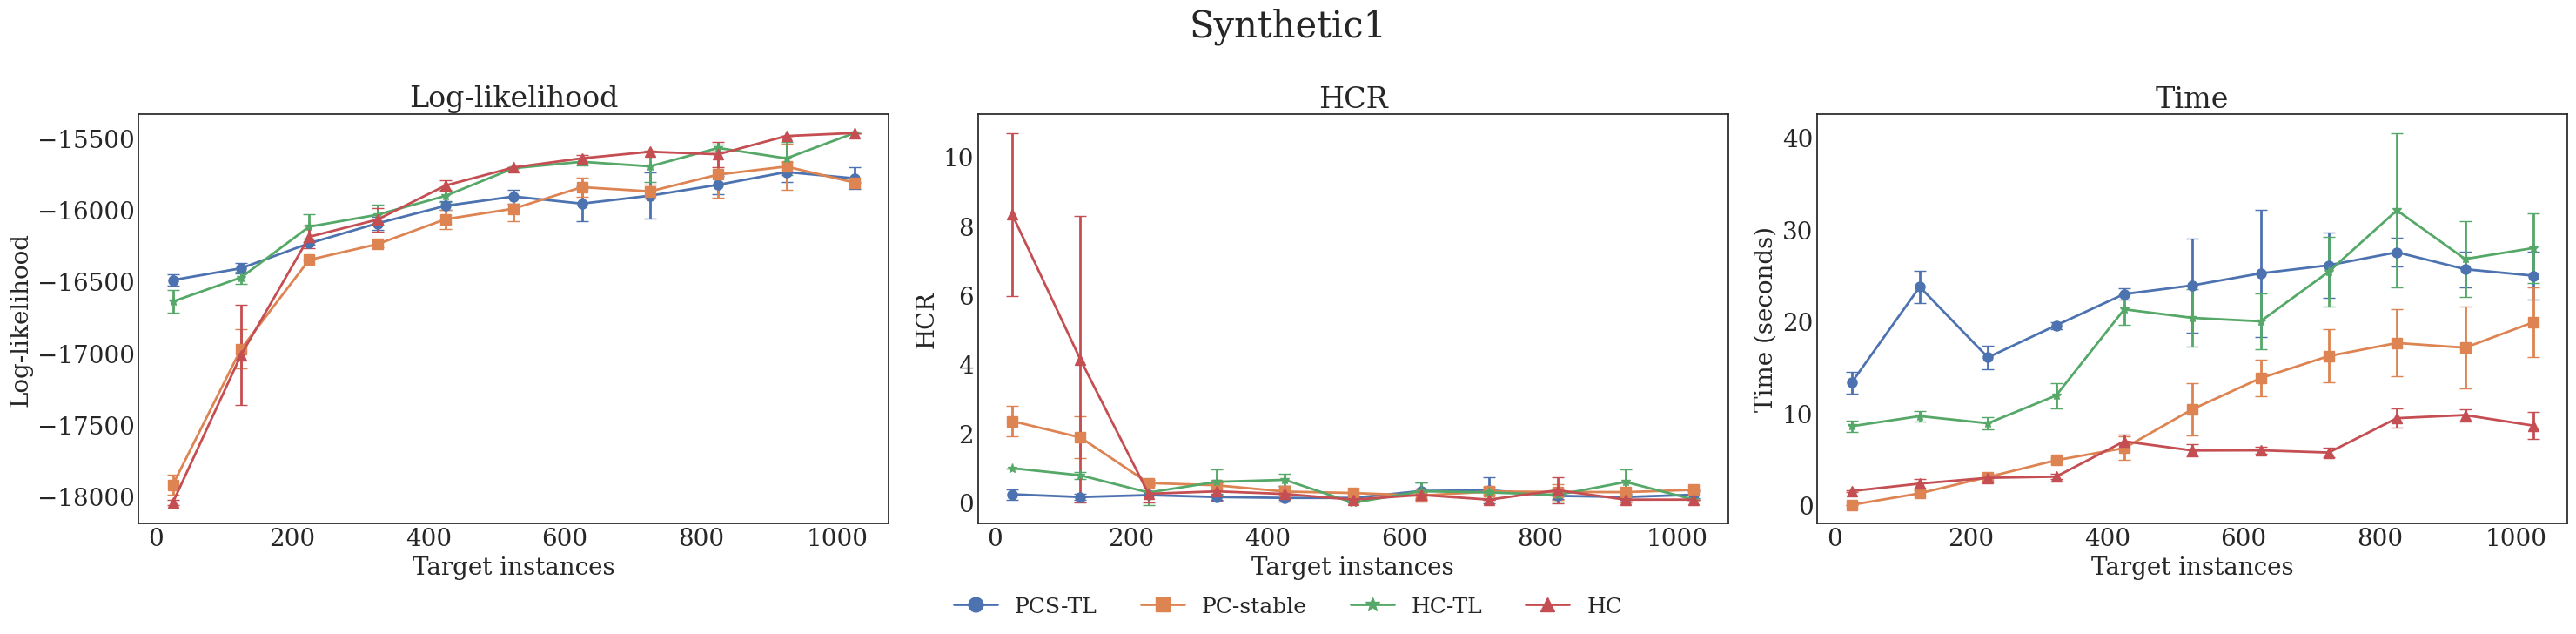

Processing Synthetic2 with 11 files


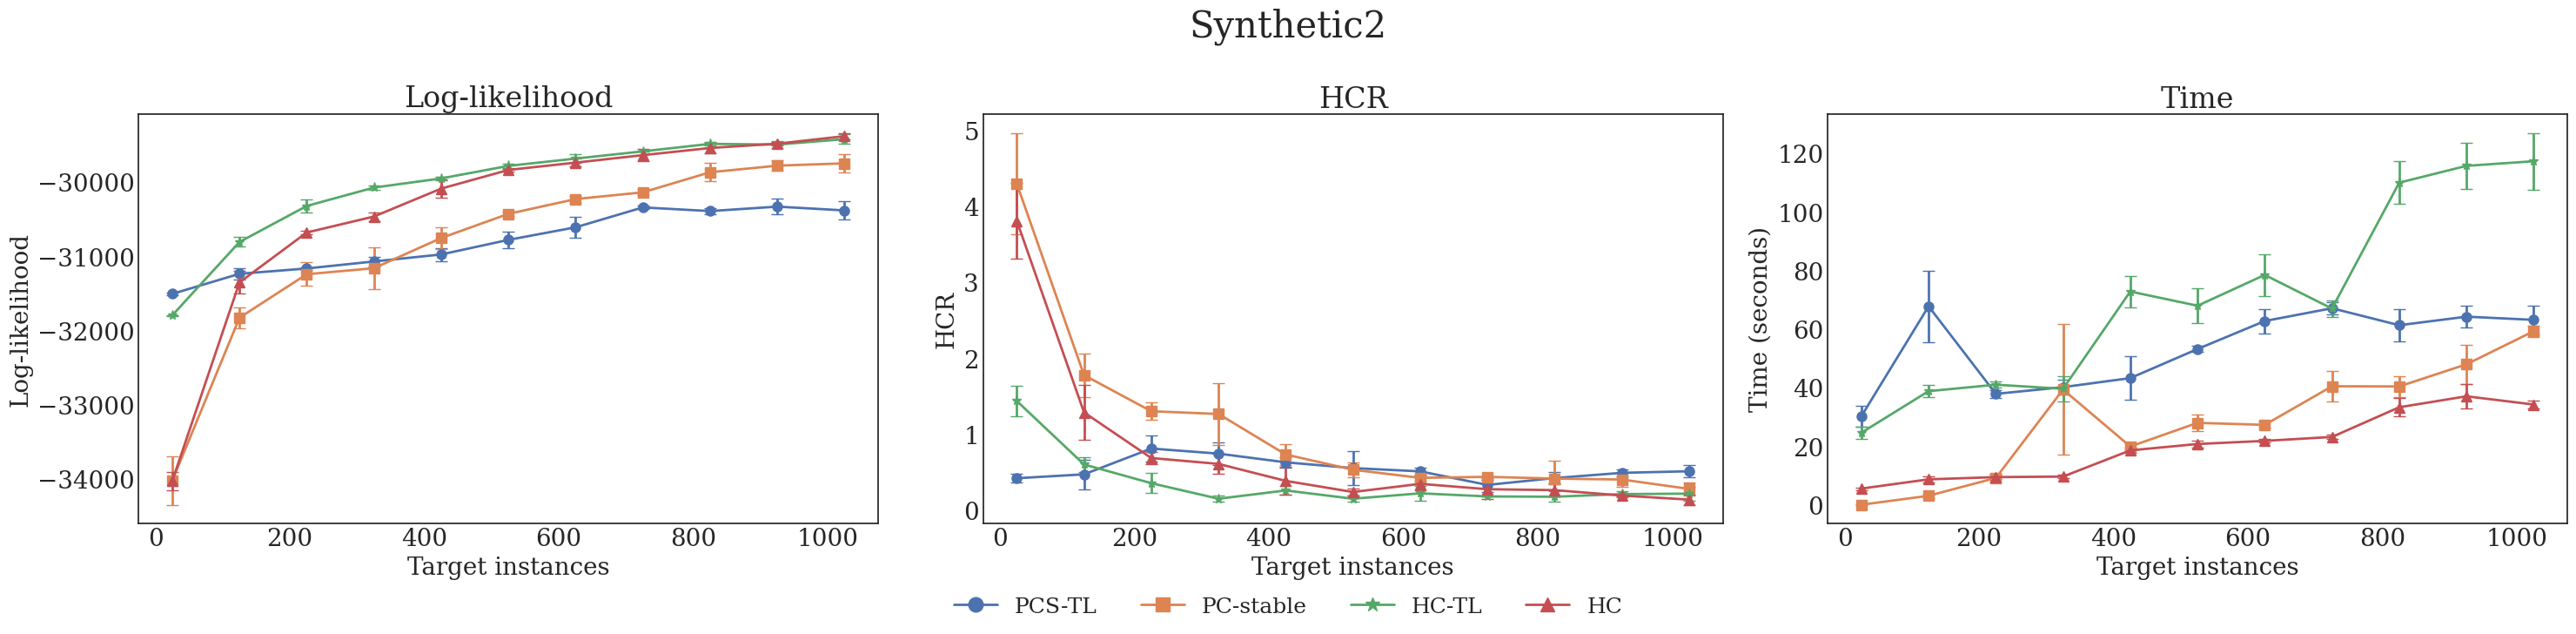

Processing Synthetic3 with 11 files


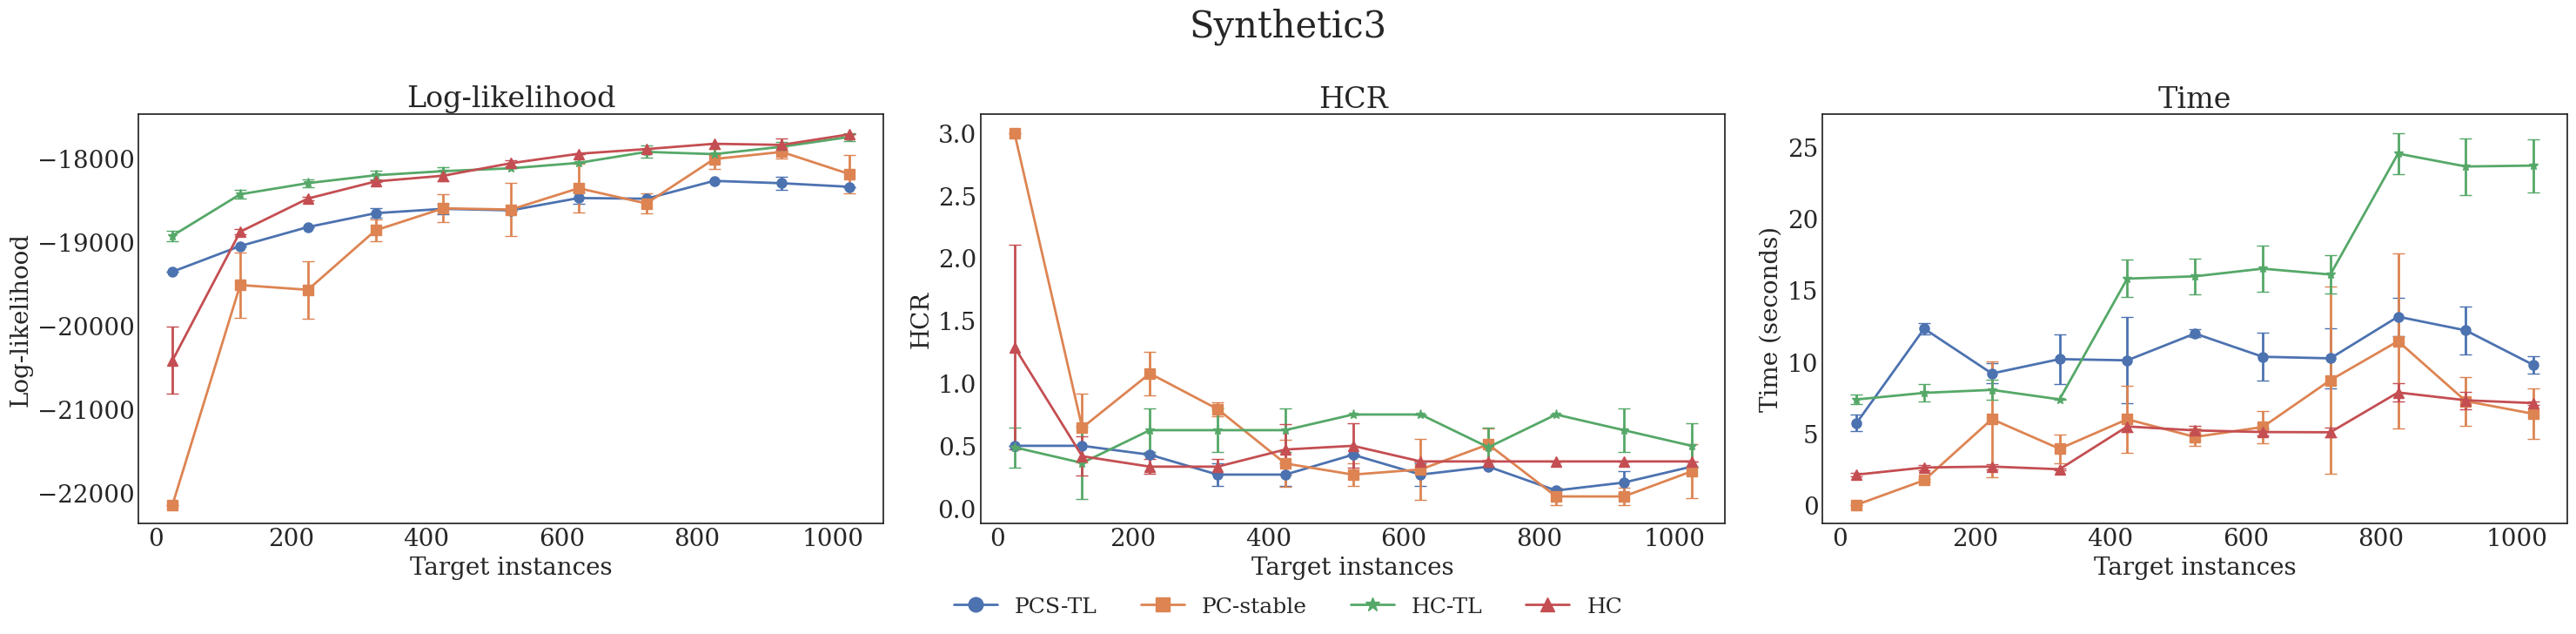

Processing Synthetic4 with 11 files


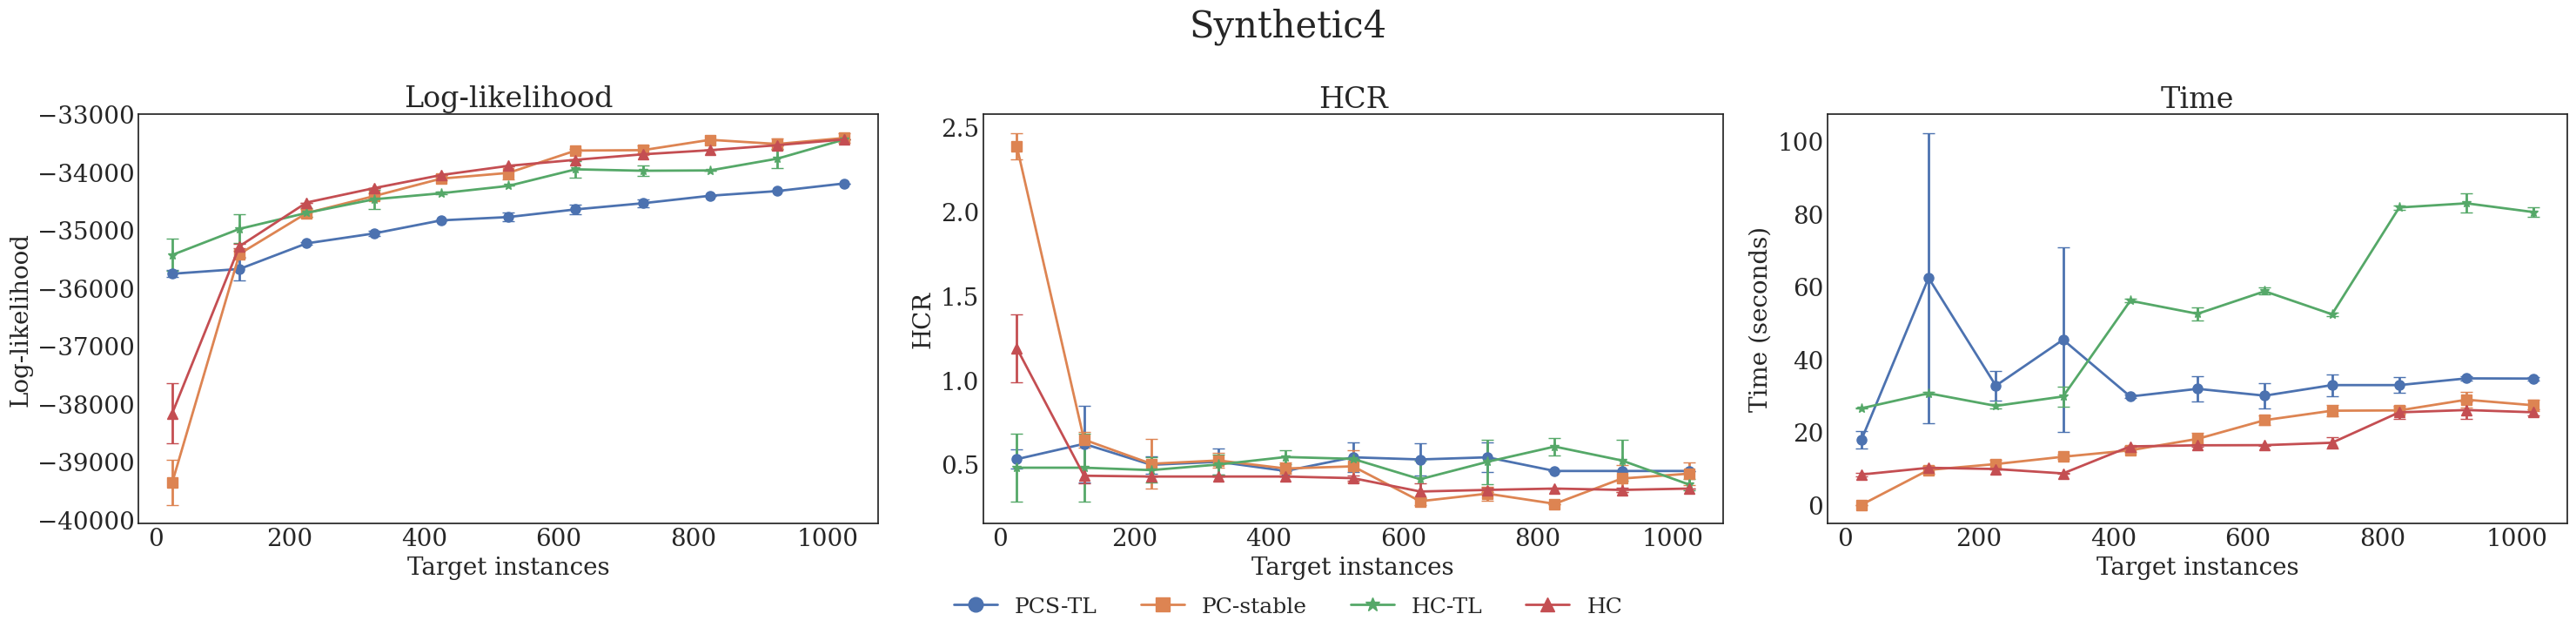

In [ ]:

syntethic010p = plot3("exps/Risk-Slocal_3k_010p/results_asynthetic/*.json", save=True, figsize=(30, 7))


Processing magic-irri with 11 files


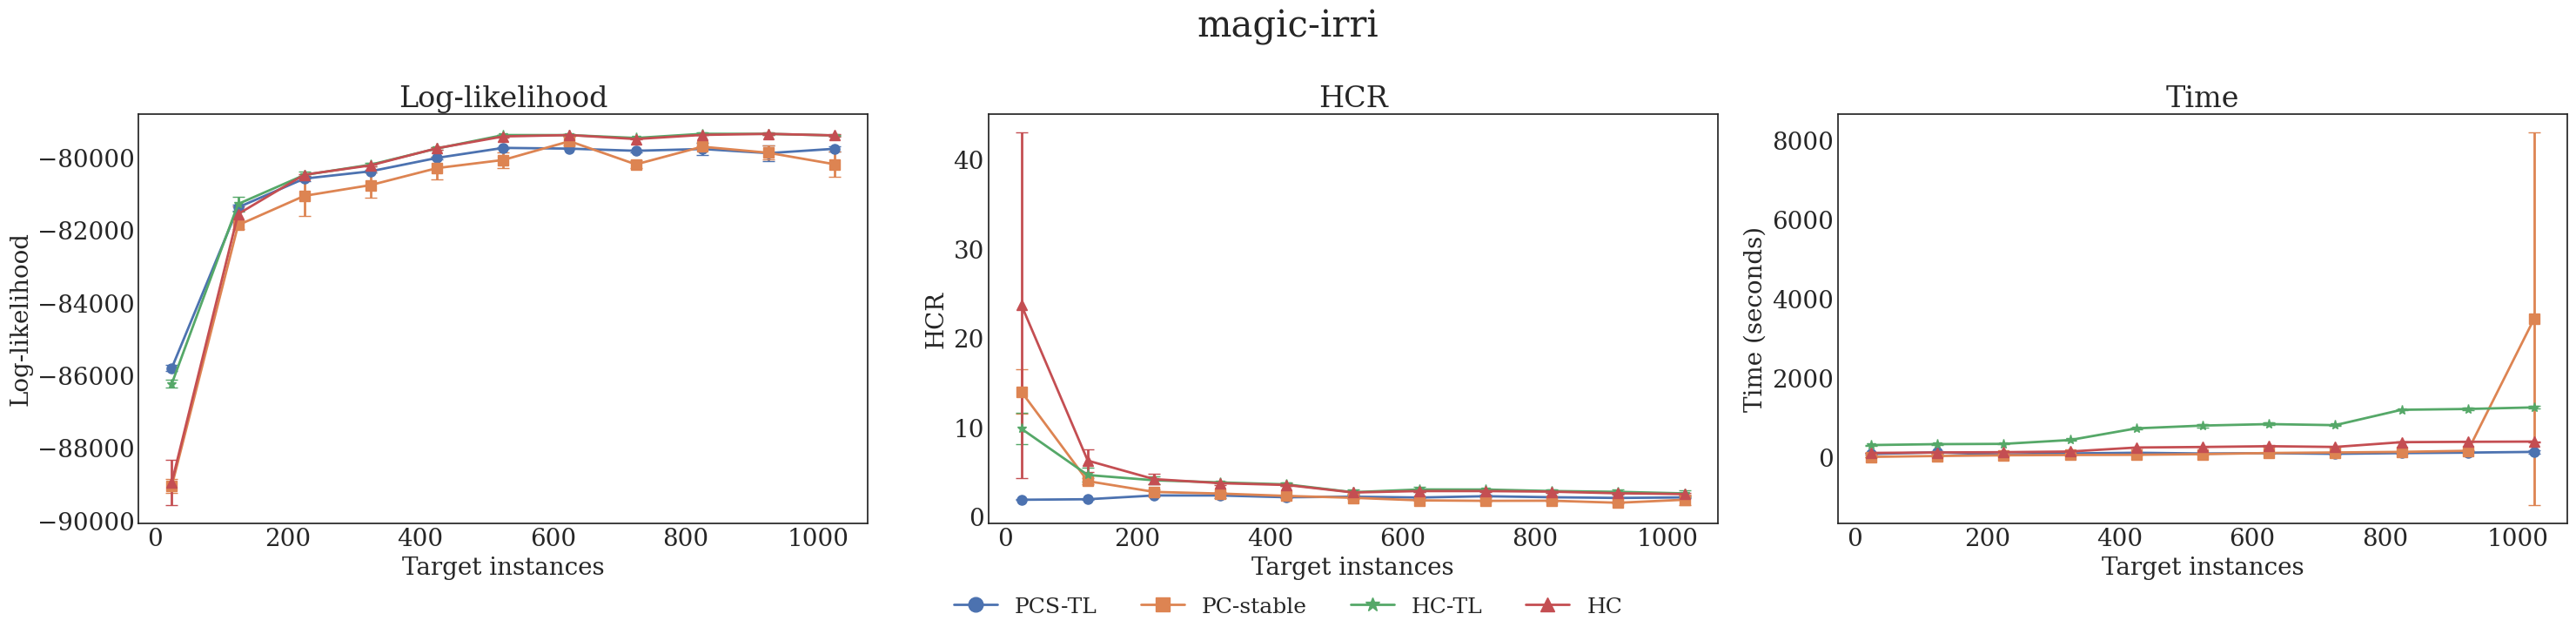

Processing magic-niab with 11 files


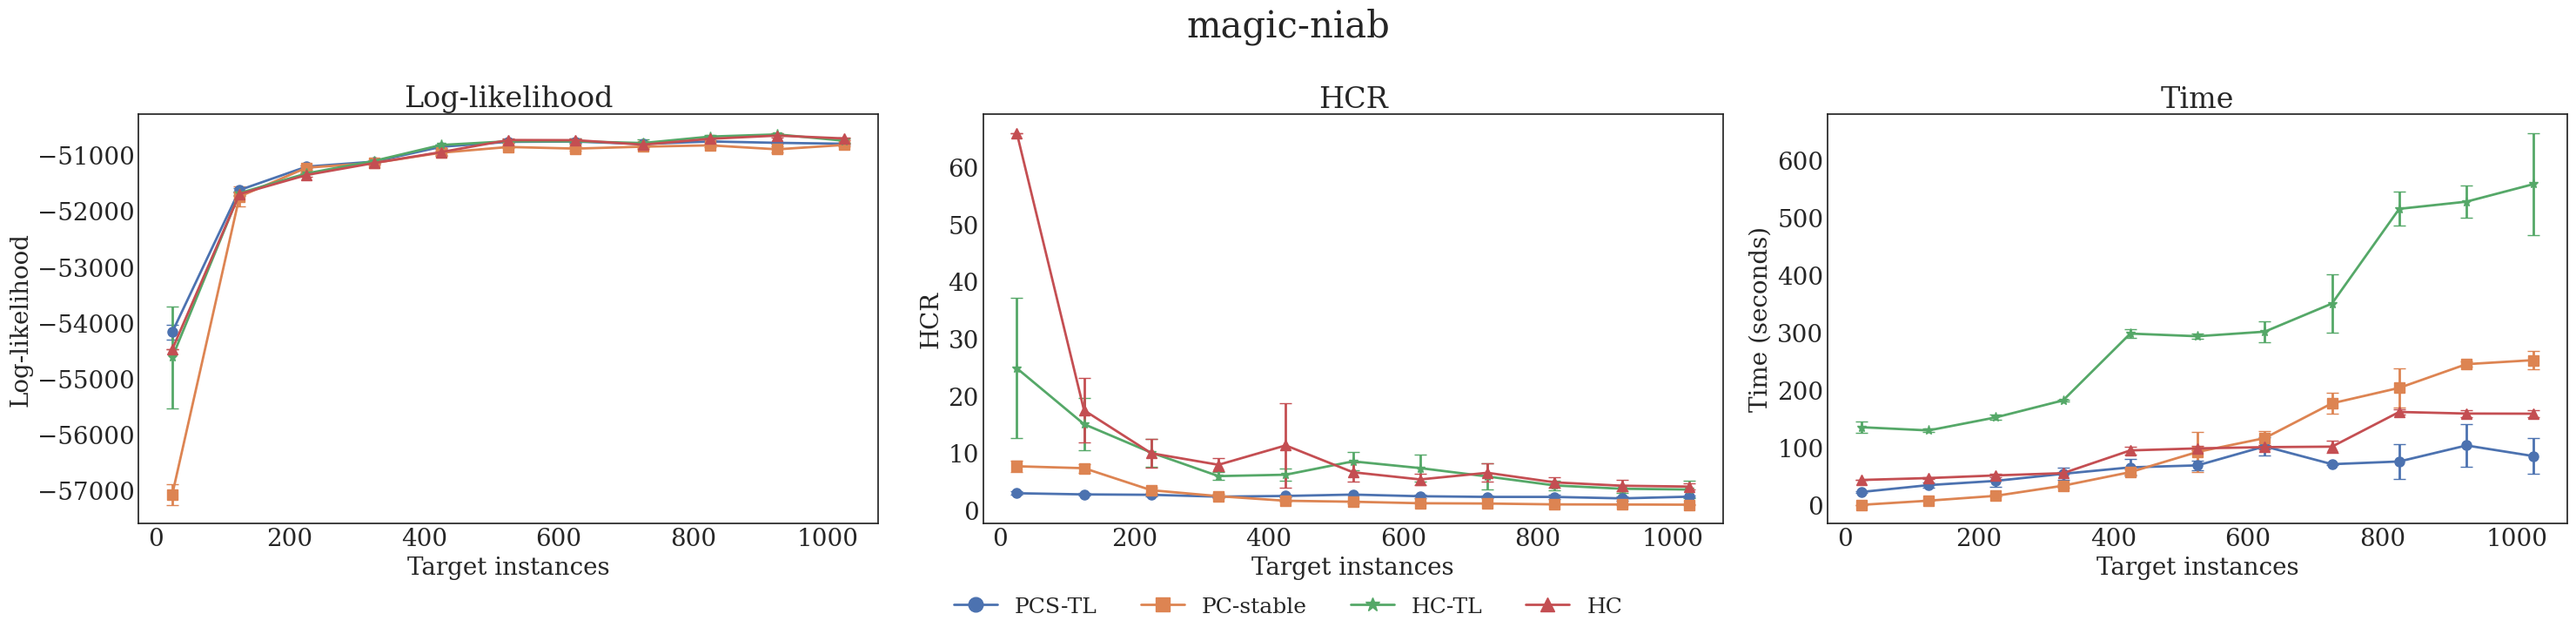

In [ ]:
bnlearn010p = plot3("exps/Risk-Slocal_3k_010p/results_bnlearn/*.json", save=True, figsize=(30, 7))

Processing Synthetic1 with 11 files


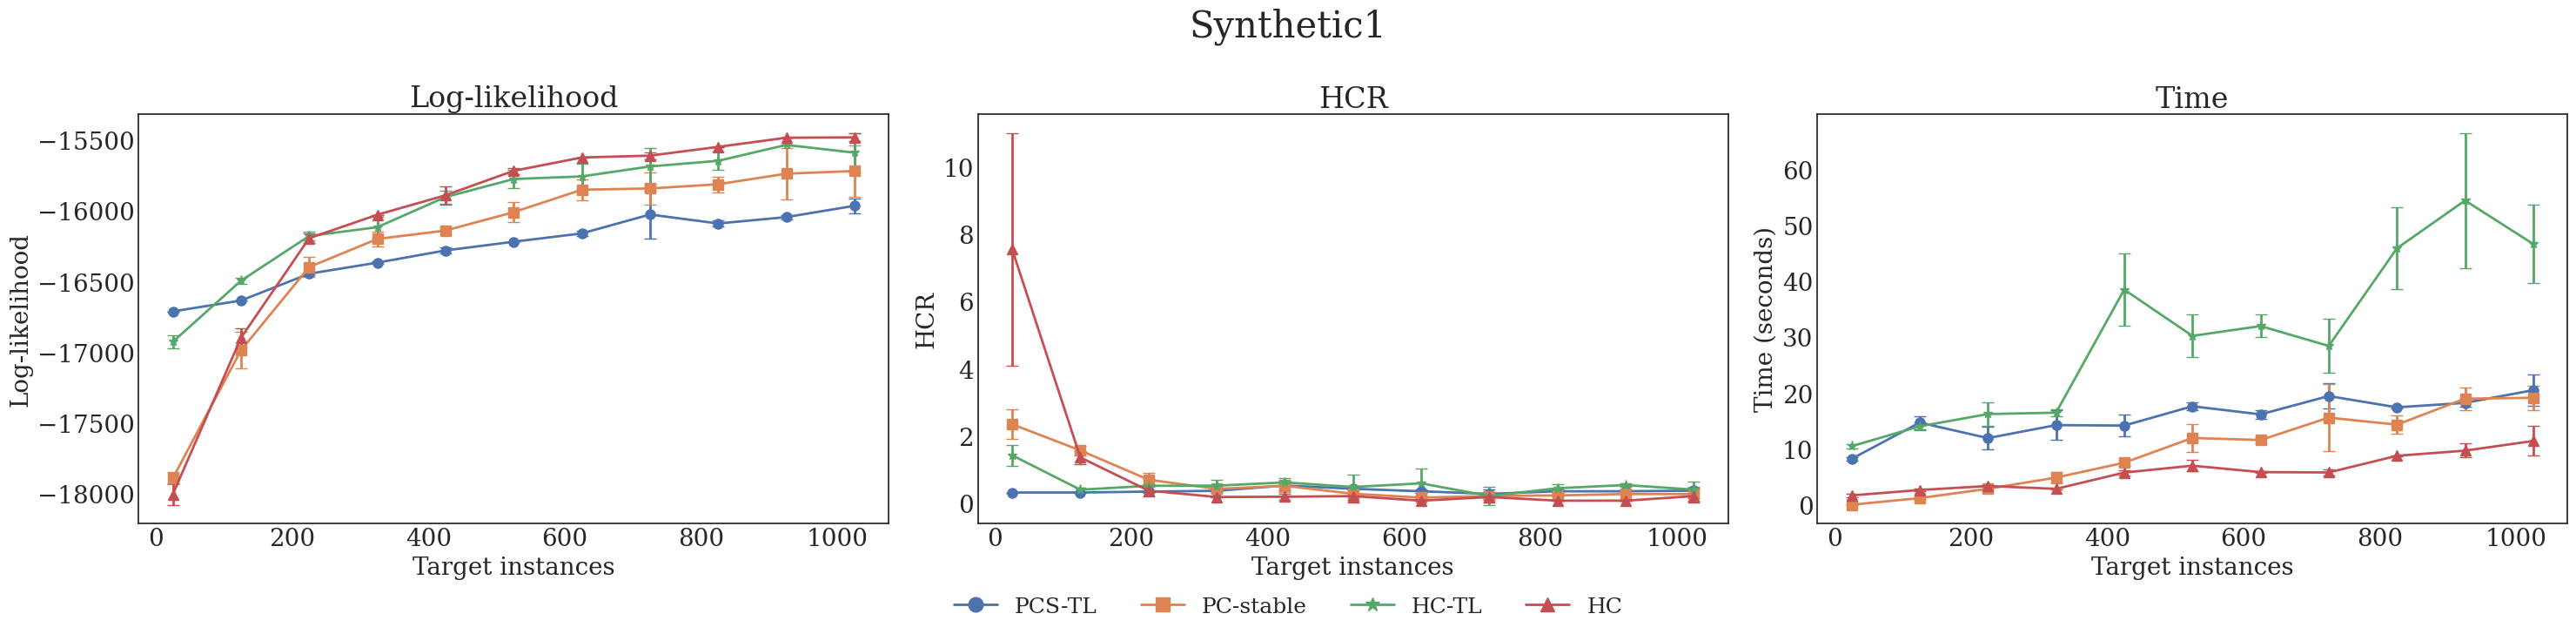

Processing Synthetic2 with 11 files


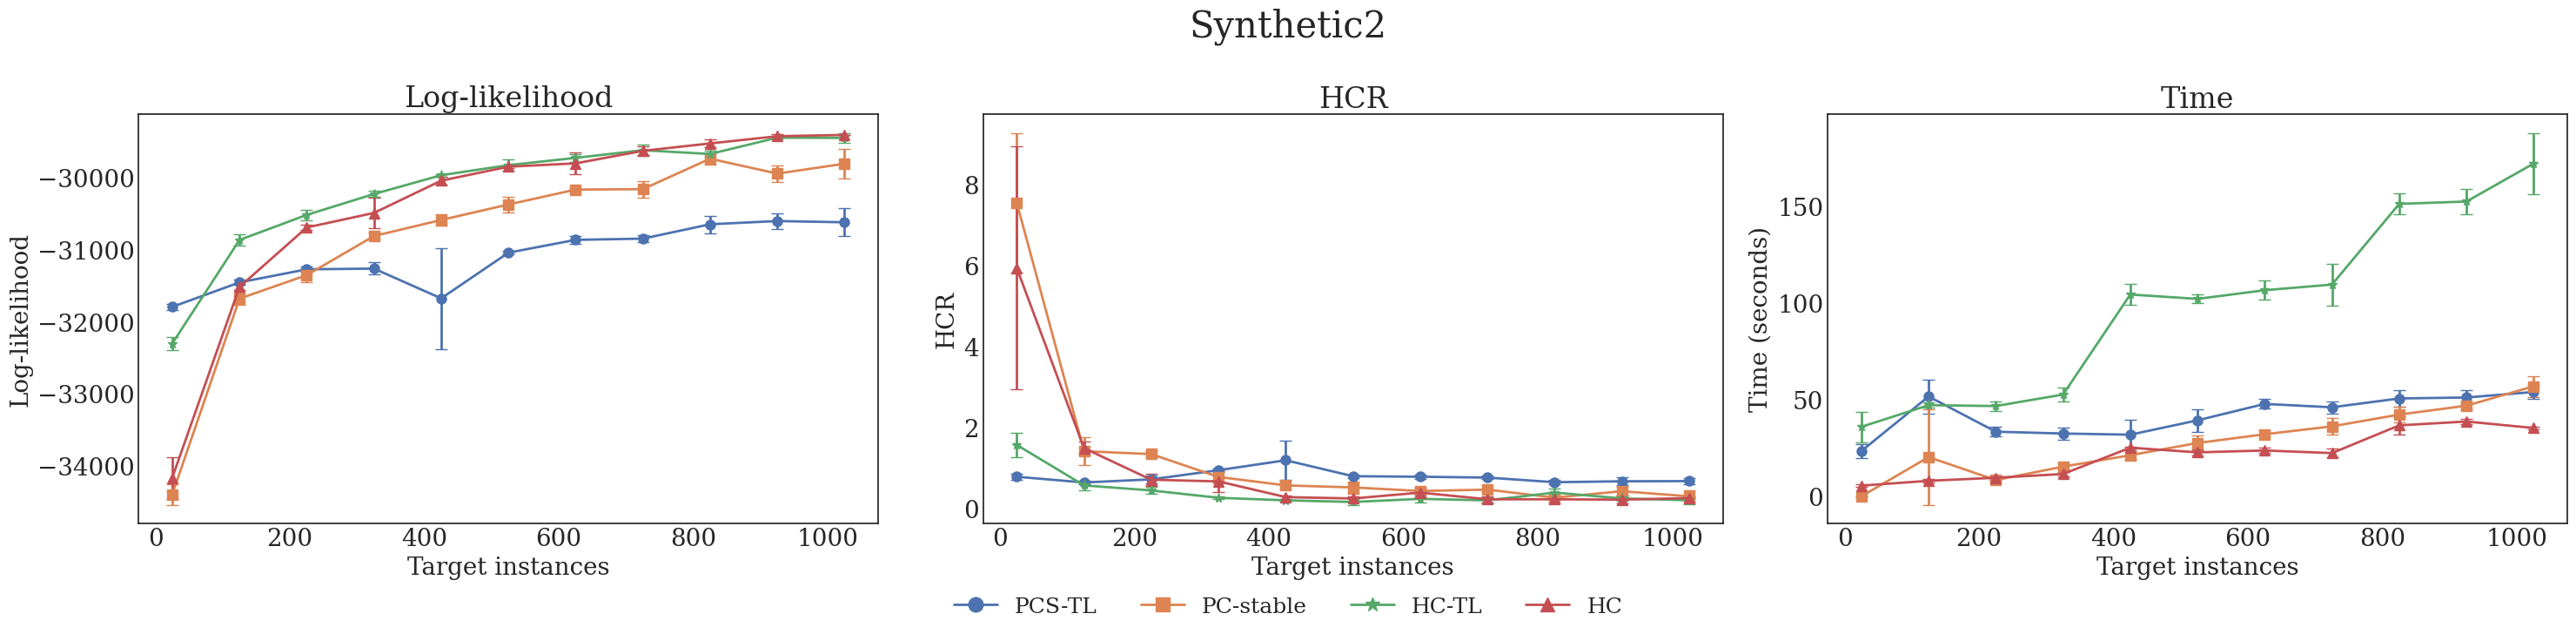

Processing Synthetic3 with 11 files


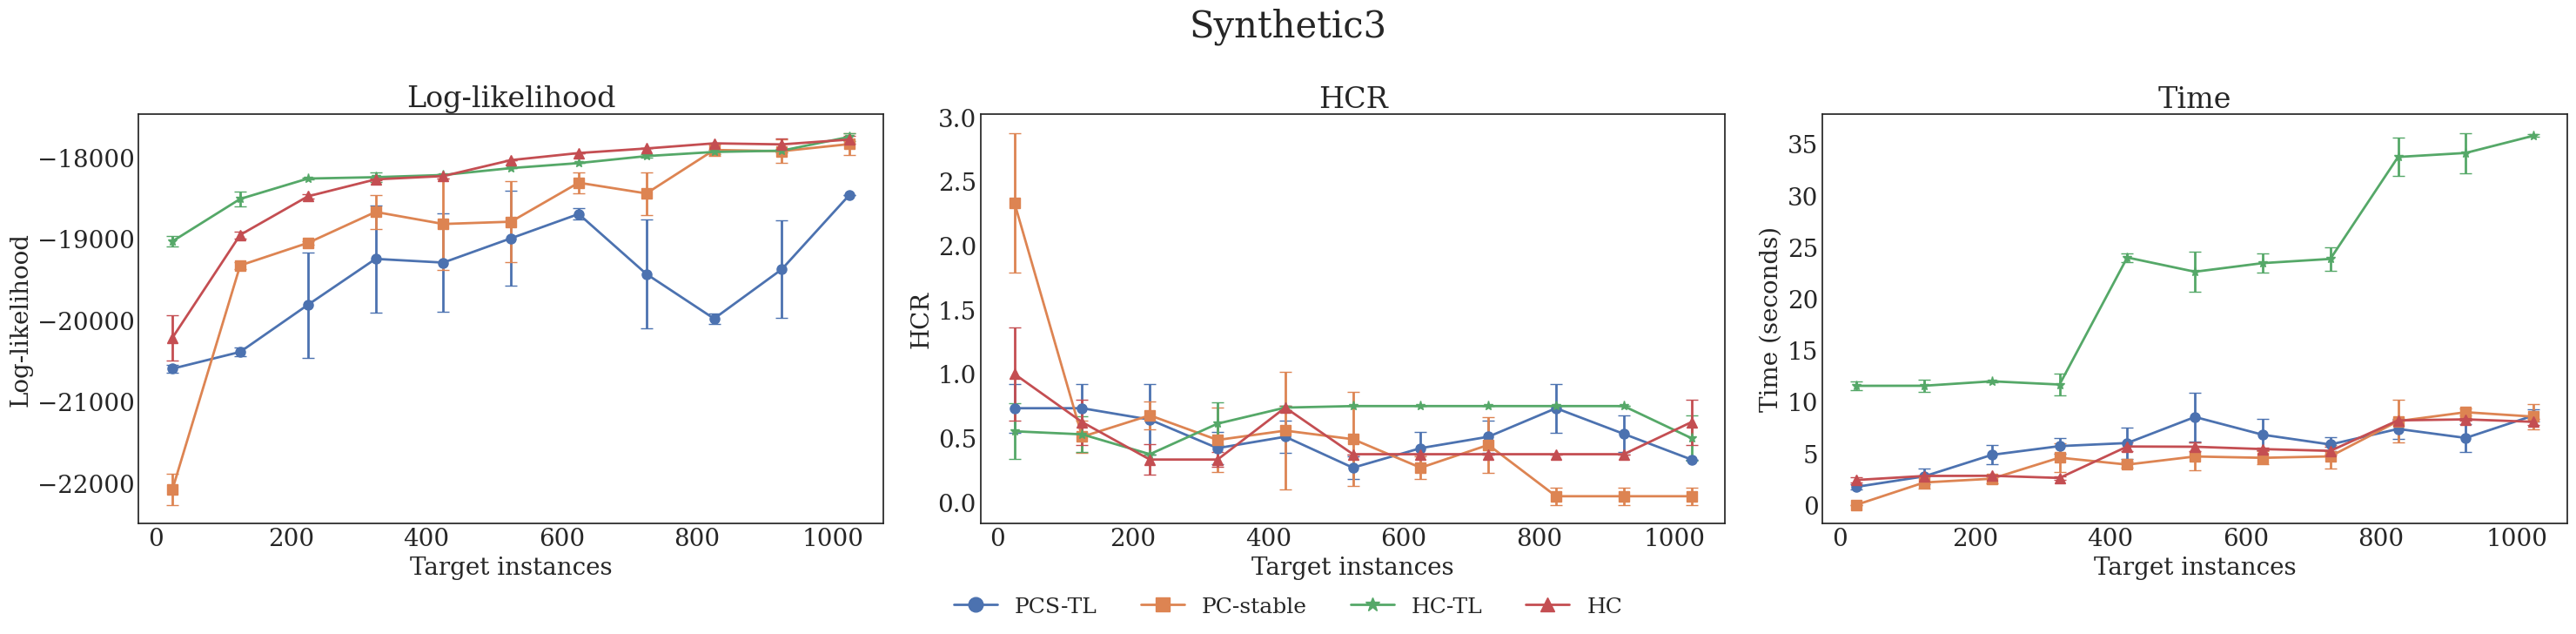

Processing Synthetic4 with 11 files


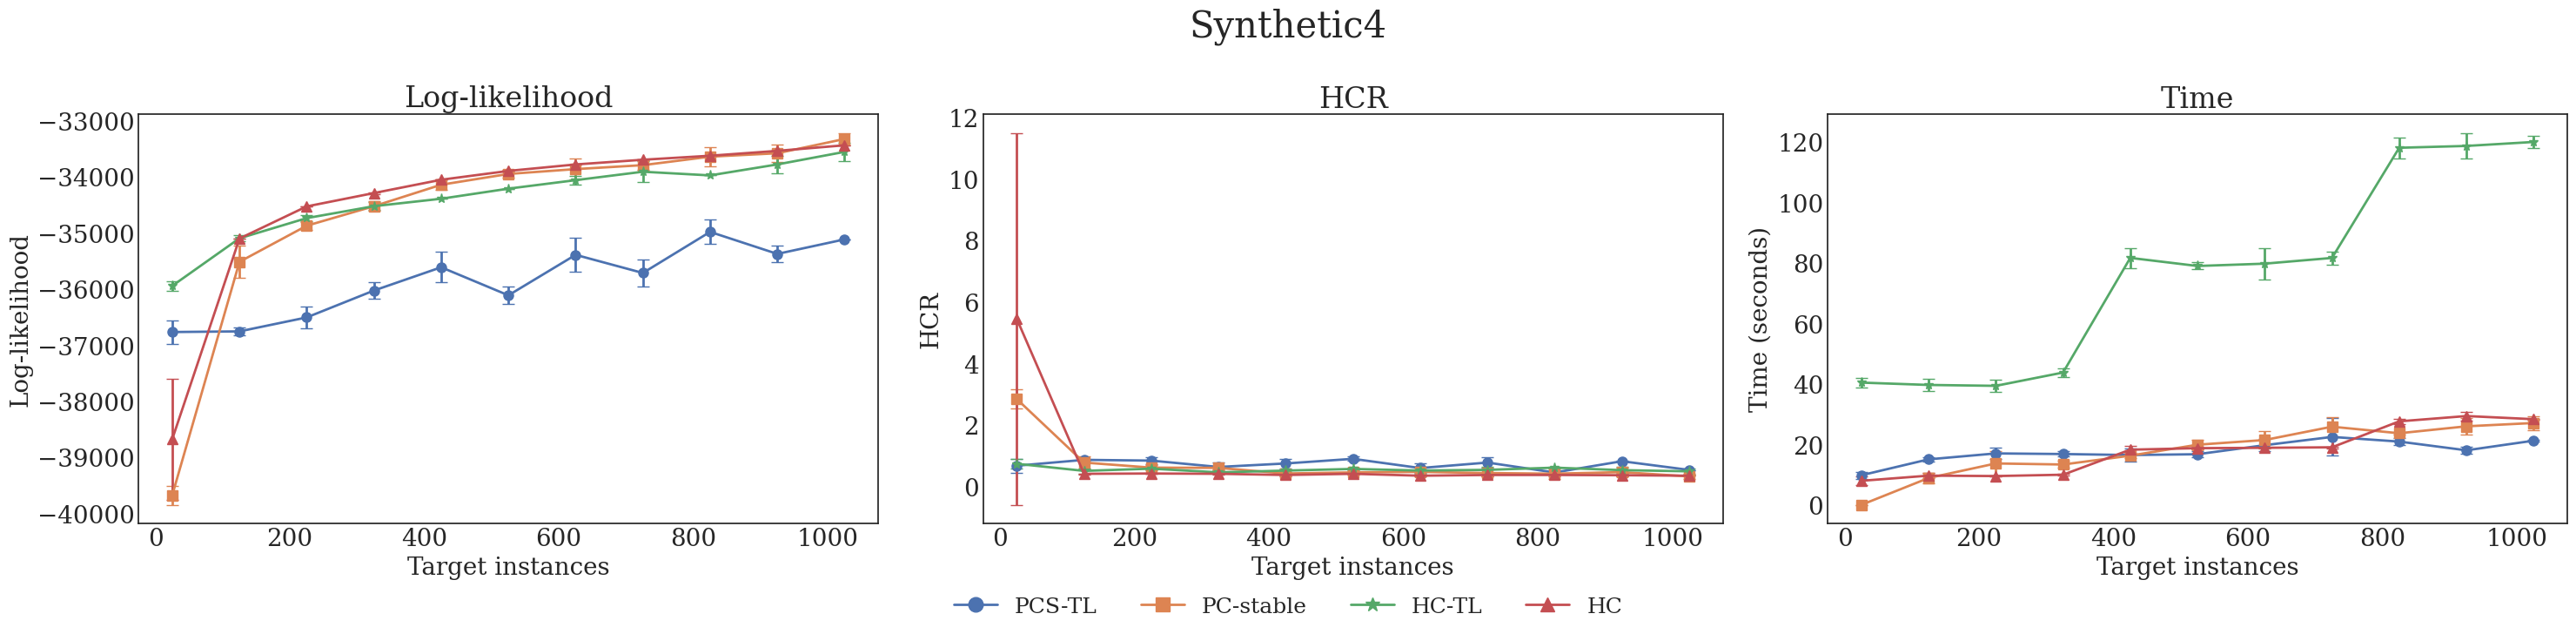

In [ ]:
synthetic51020p = plot3("exps/Risk-Slocal_3k_51020p/results_asynthetic/*.json", save=True, figsize=(30, 7))

Processing magic-irri with 11 files


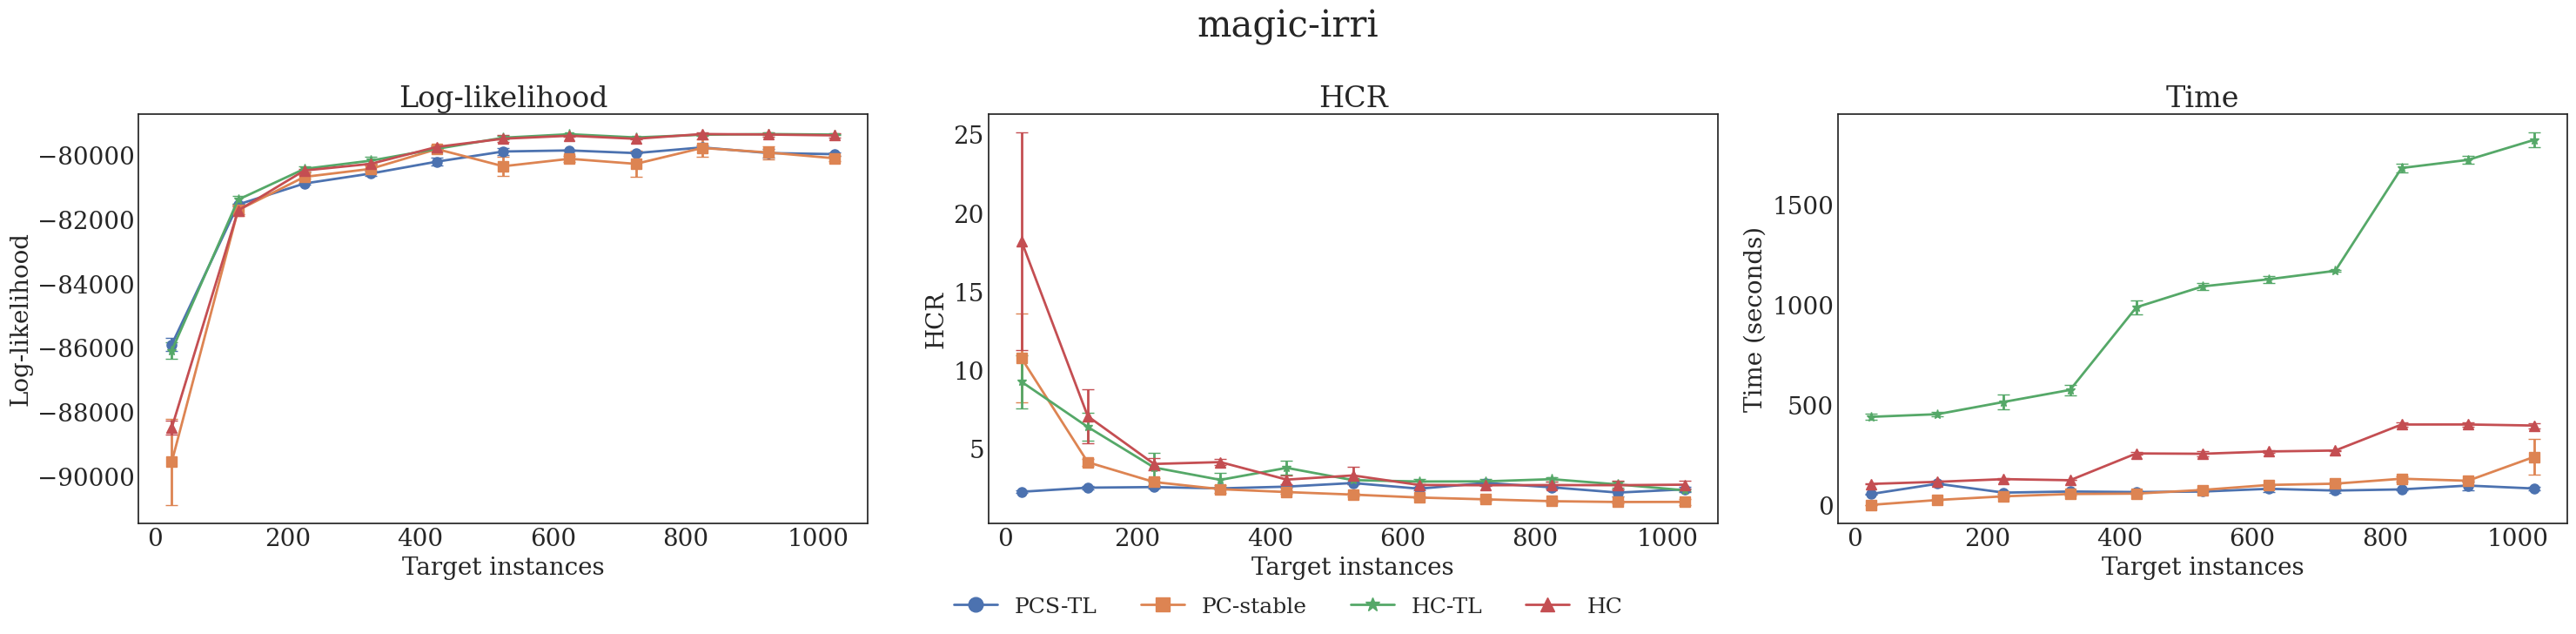

Processing magic-niab with 11 files


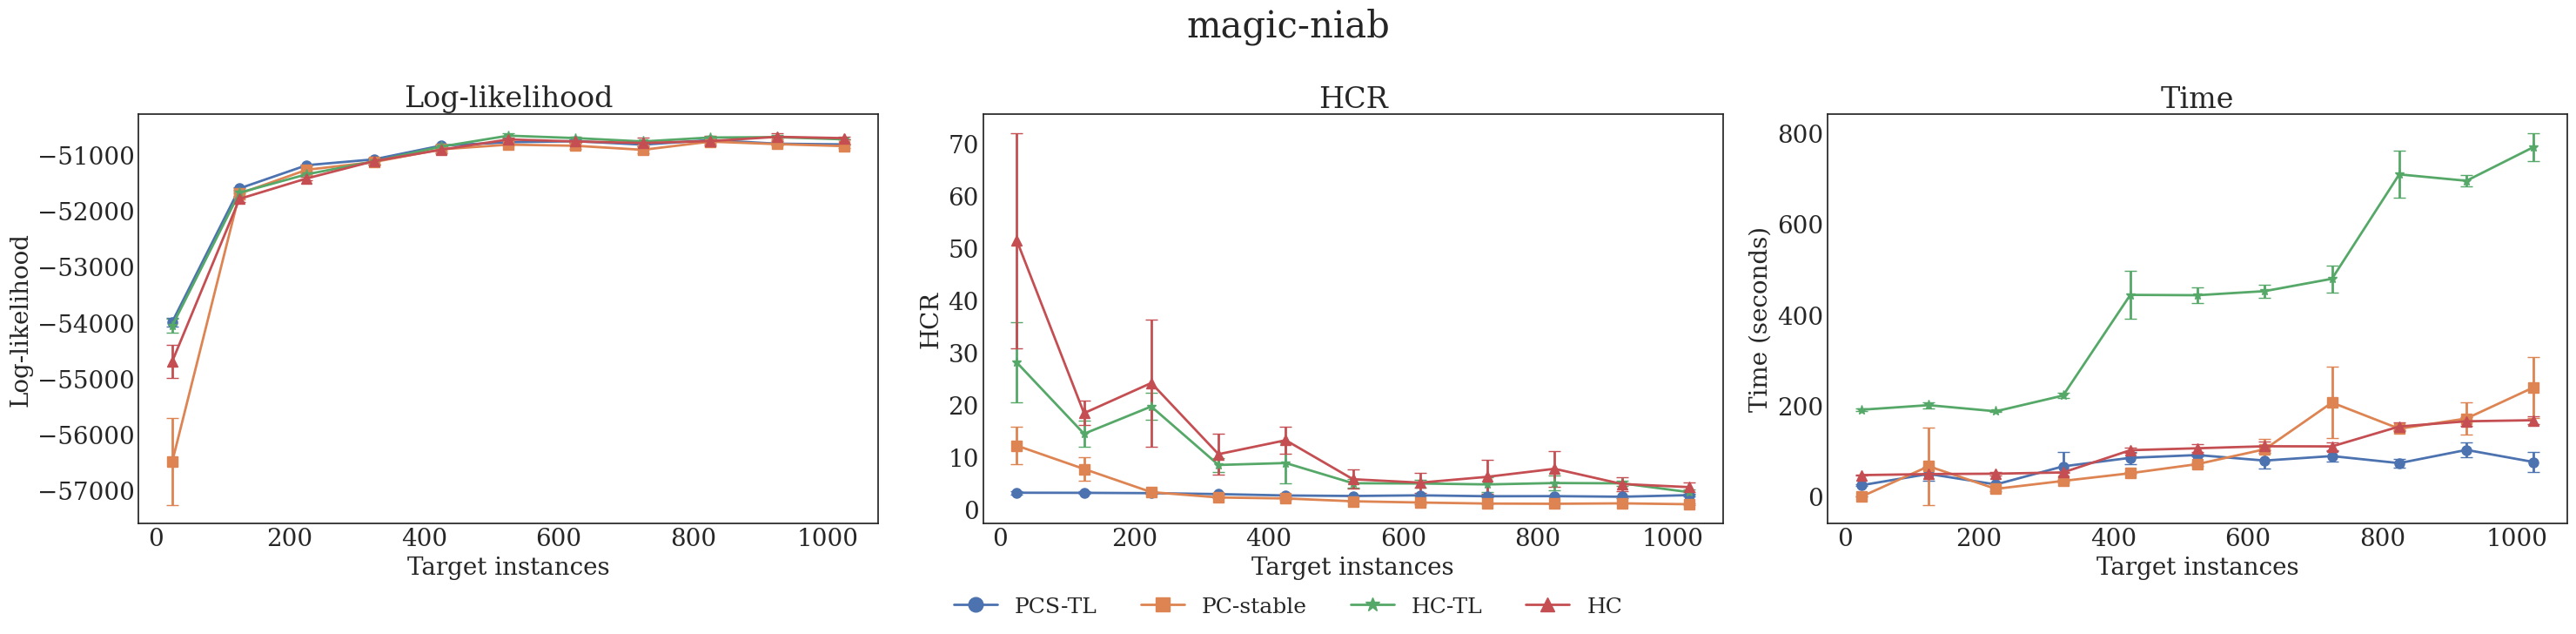

In [ ]:
bnlearn51020p = plot3("exps/Risk-Slocal_3k_51020p/results_bnlearn/*.json", save=True, figsize=(30, 7))

Processing 1 with 11 files


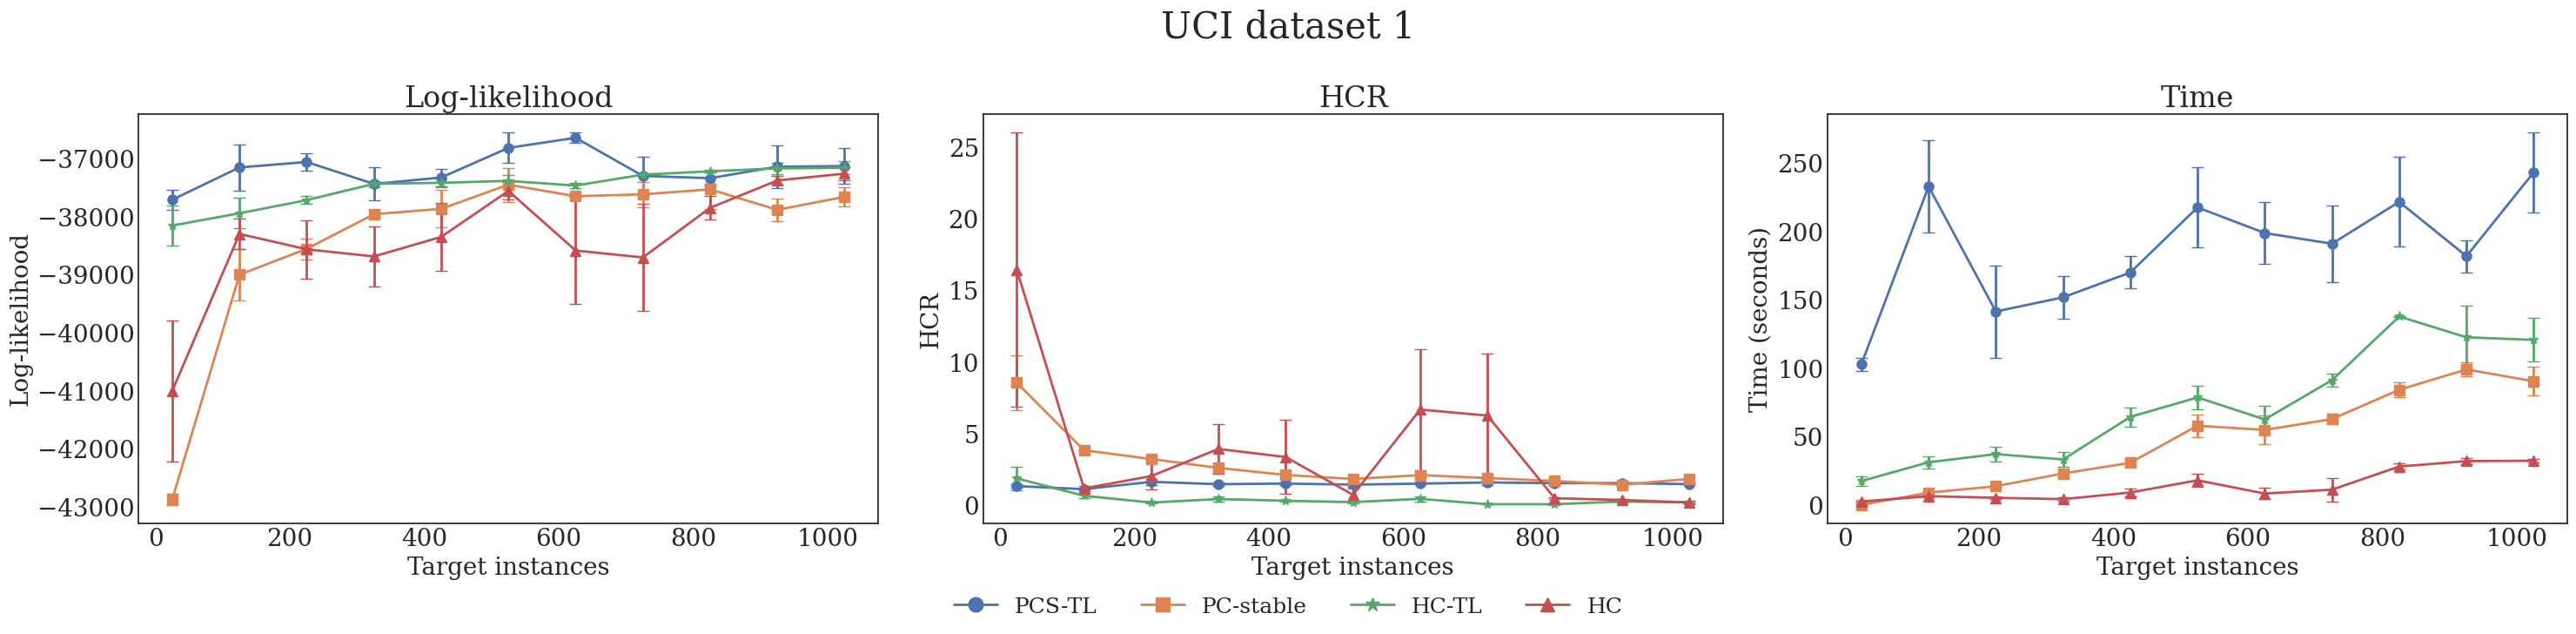

Processing 2 with 11 files


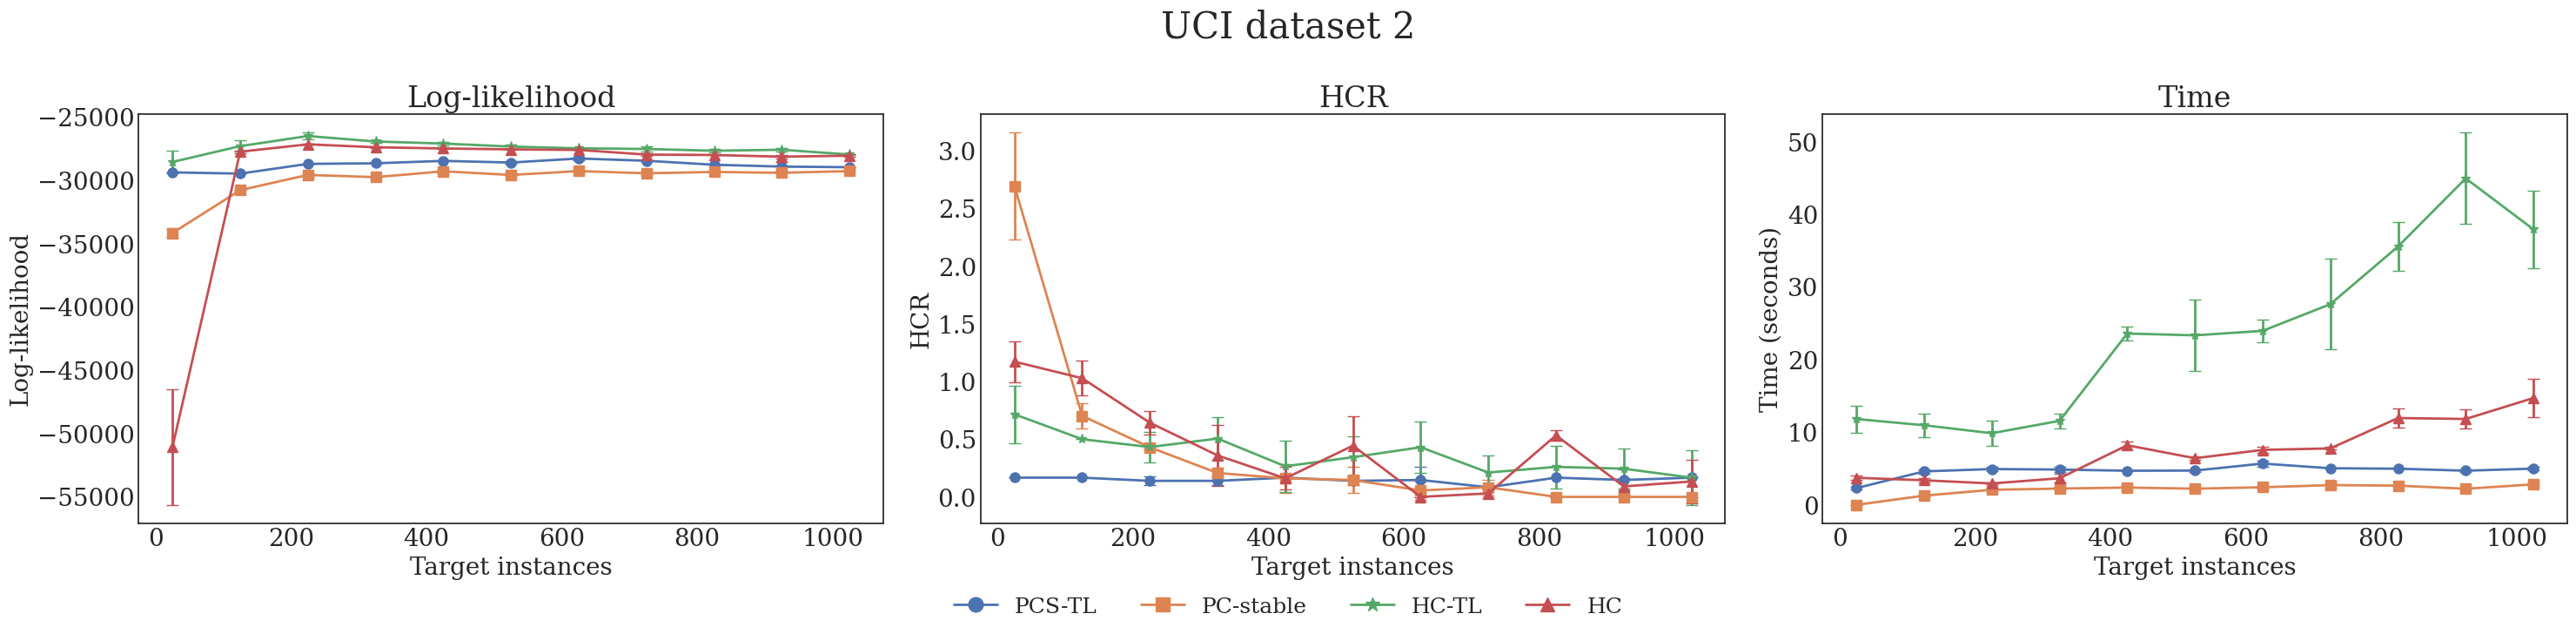

Processing 3 with 11 files


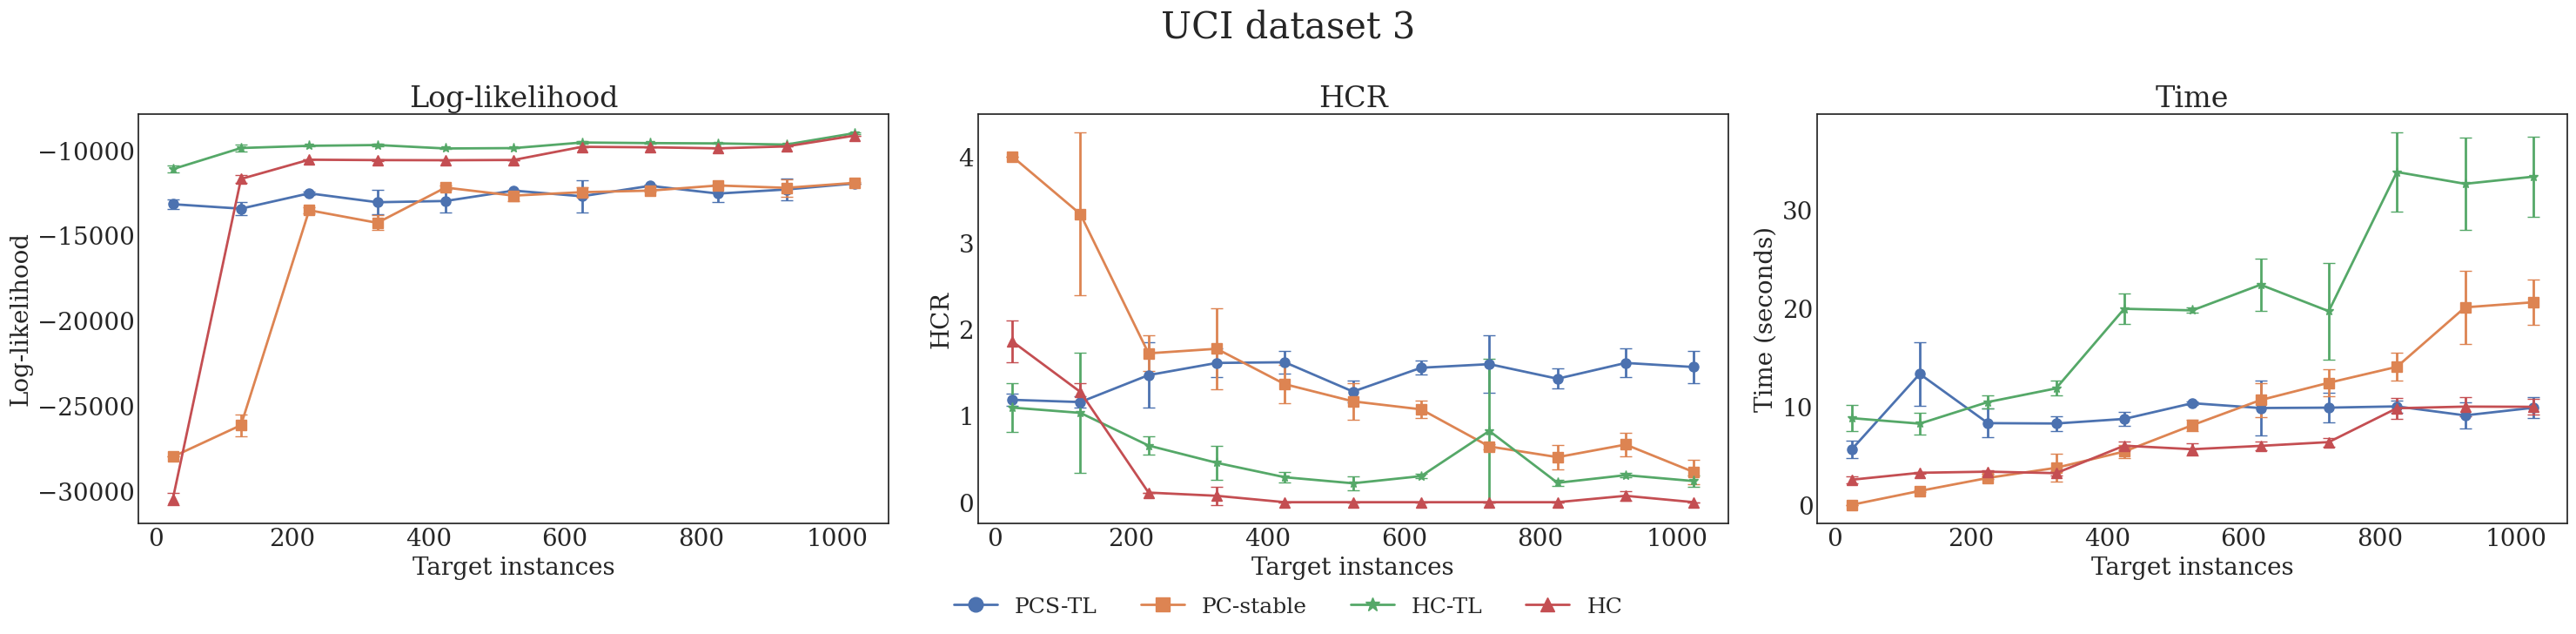

Processing 4 with 11 files


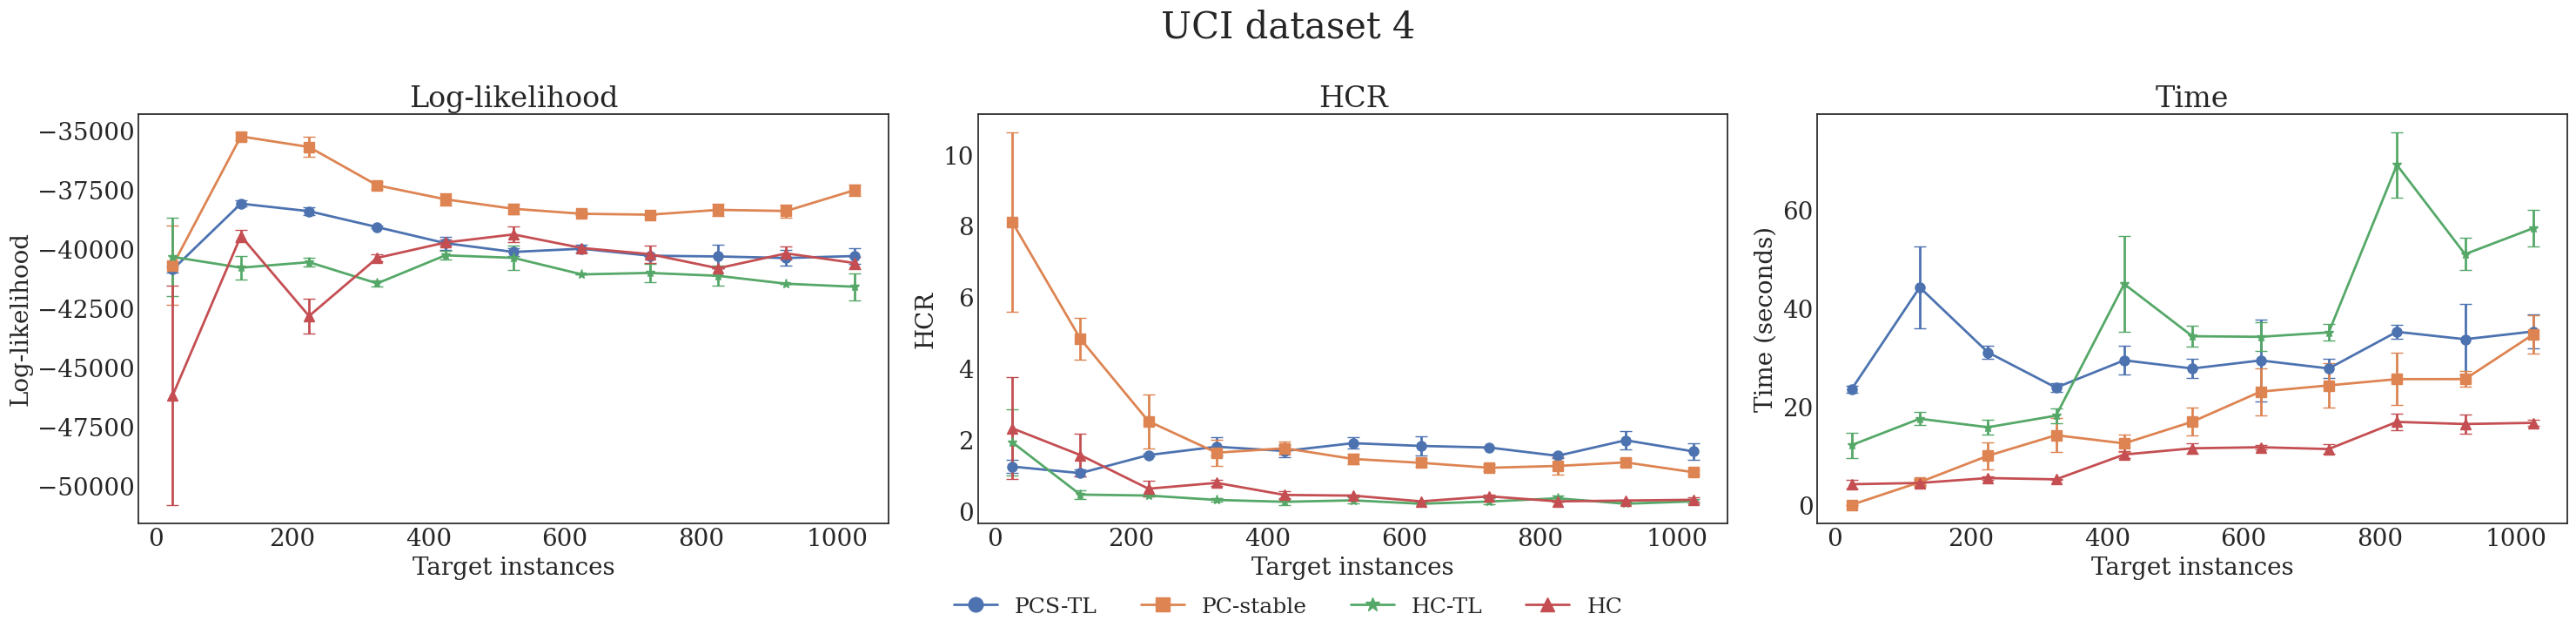

Processing 5 with 11 files


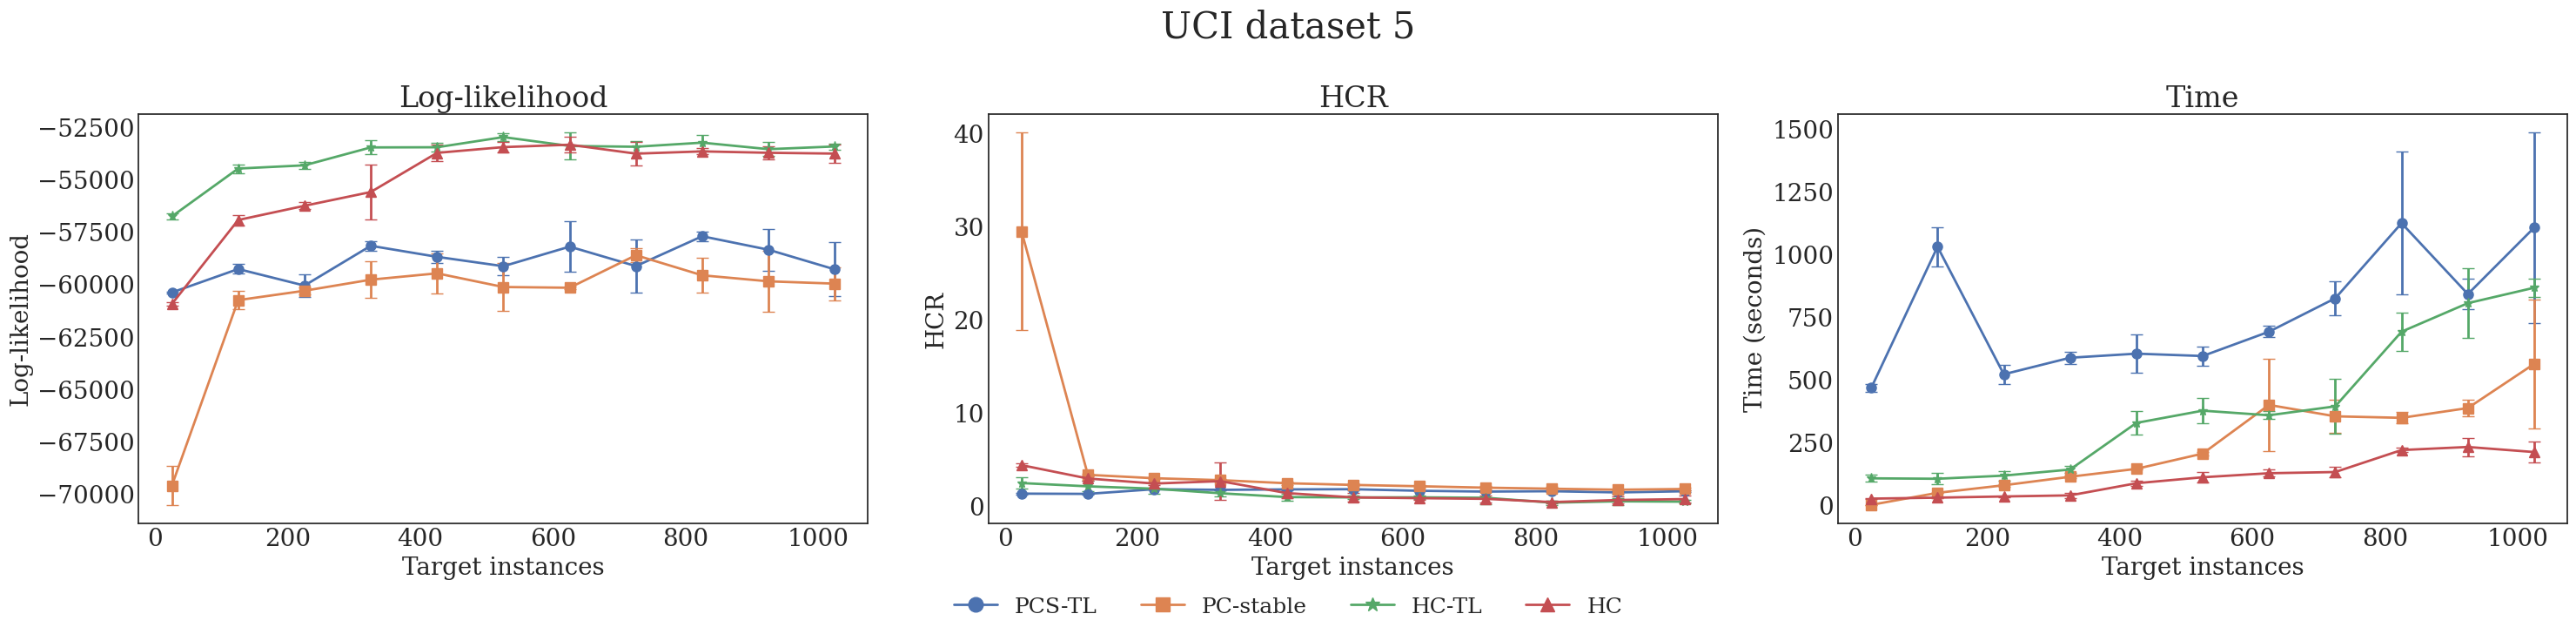

In [ ]:
uci5_010p = plot3("exps/Risk-Slocal_3k_010p/results_uciml/*.json", doPCHC=(True, True), save=True, figsize=(30, 7))

Processing 1 with 11 files


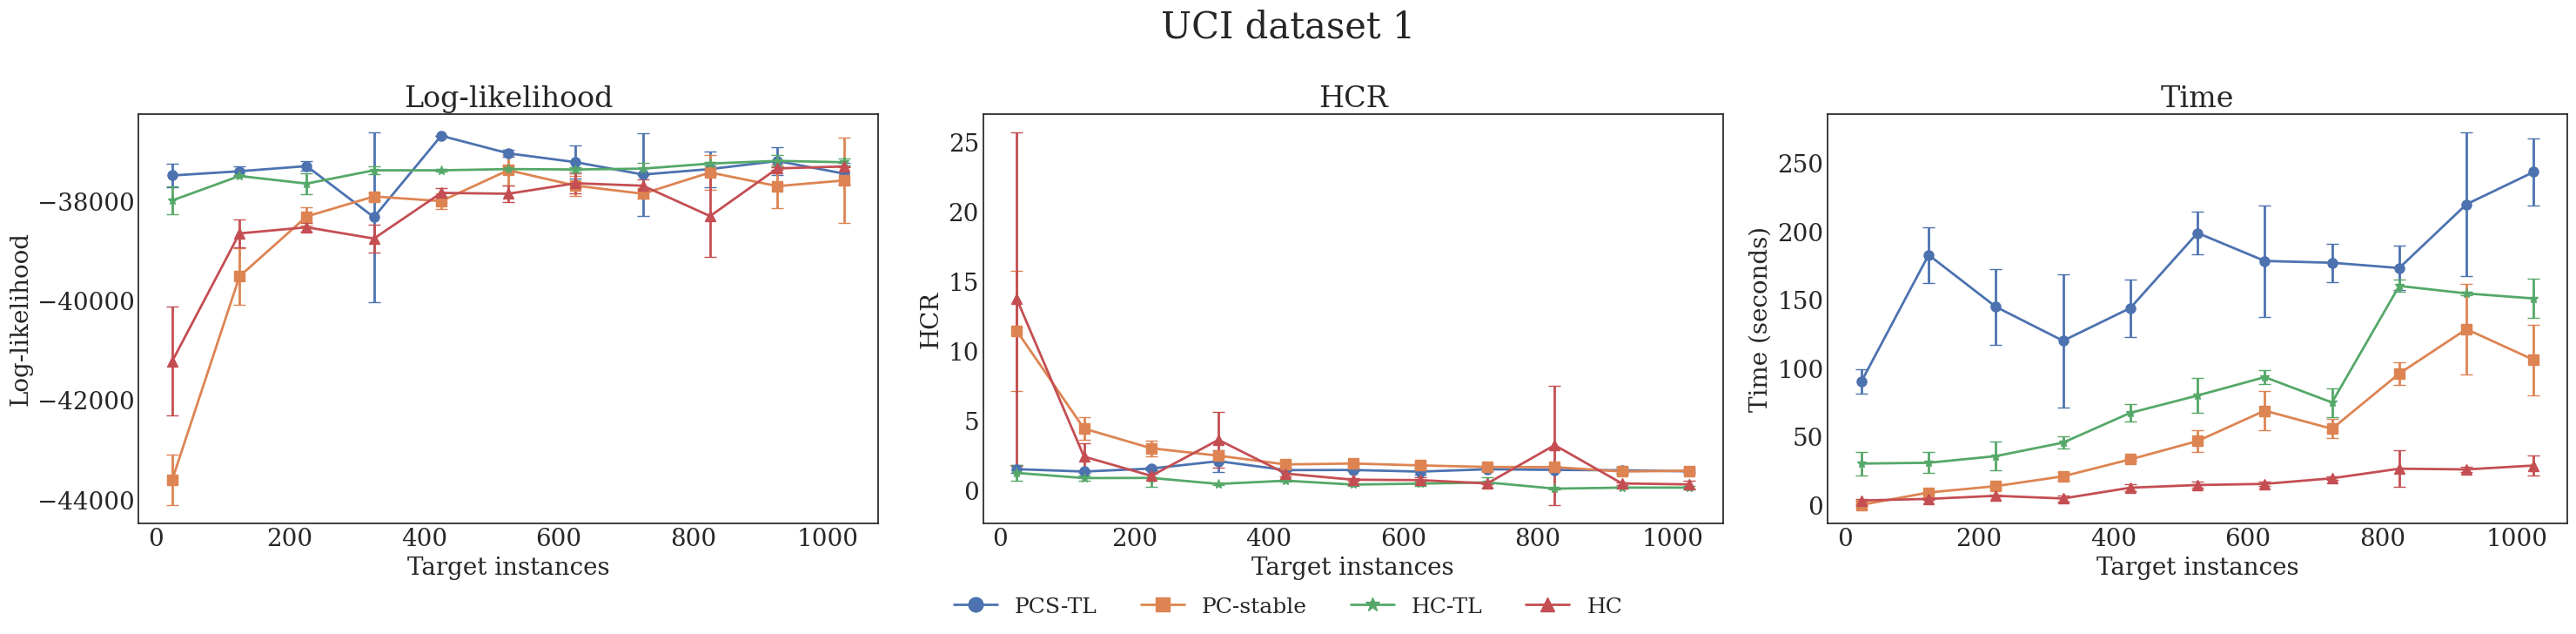

Processing 2 with 11 files


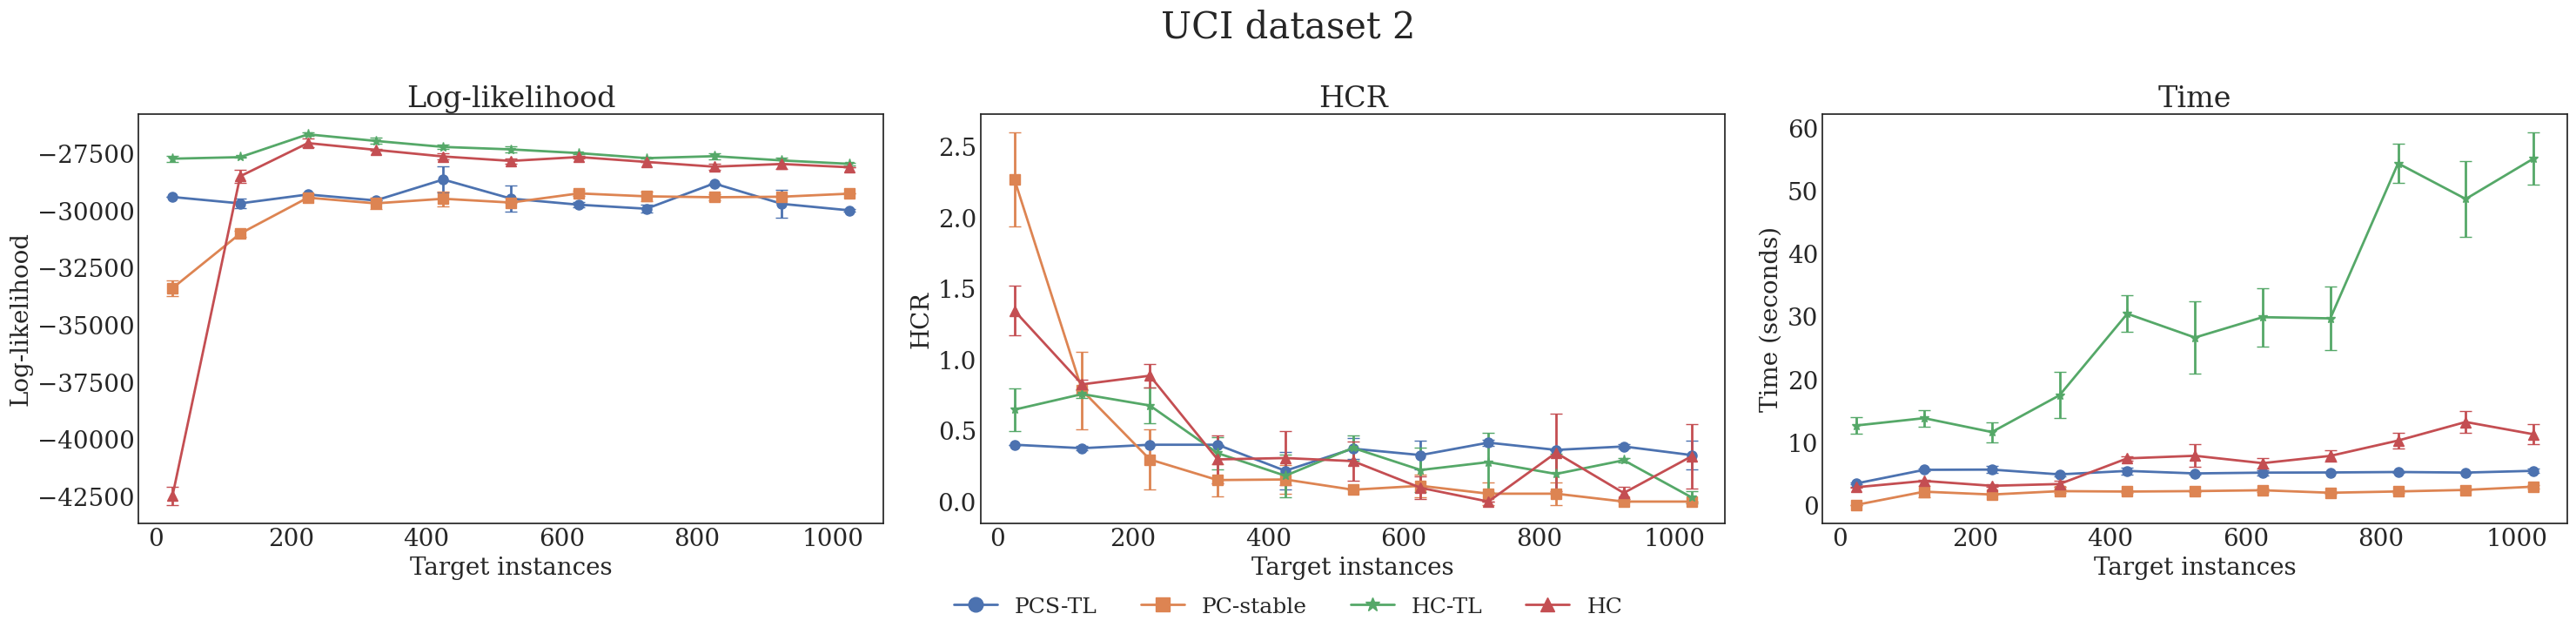

Processing 3 with 11 files


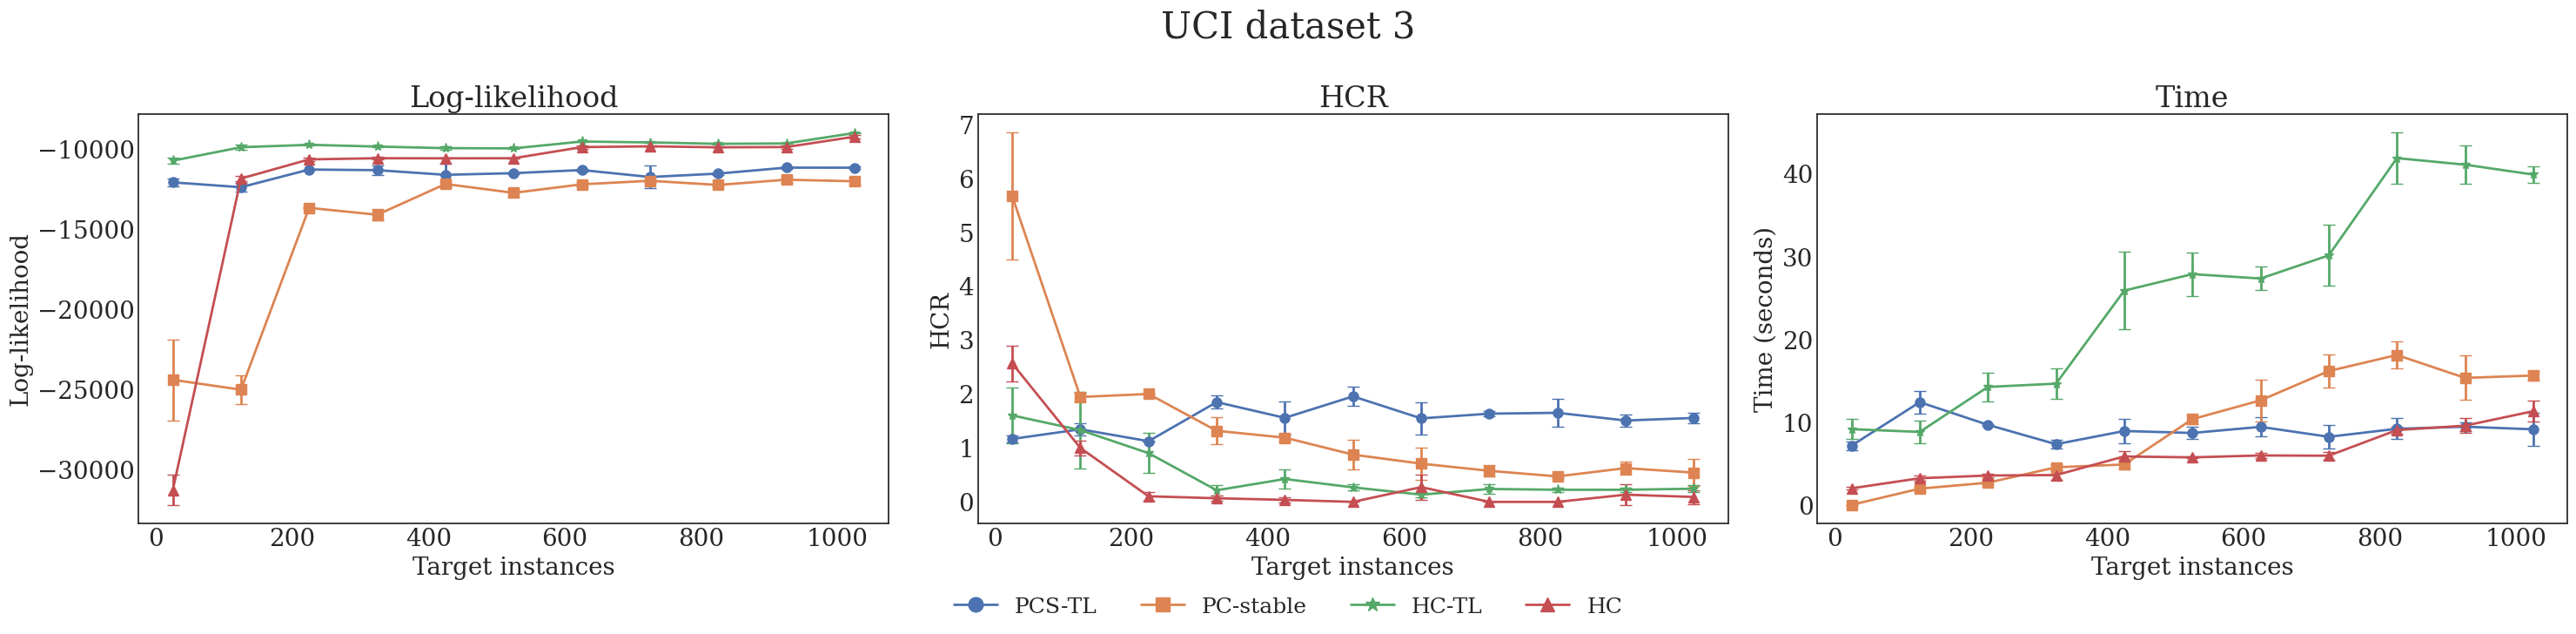

Processing 4 with 11 files


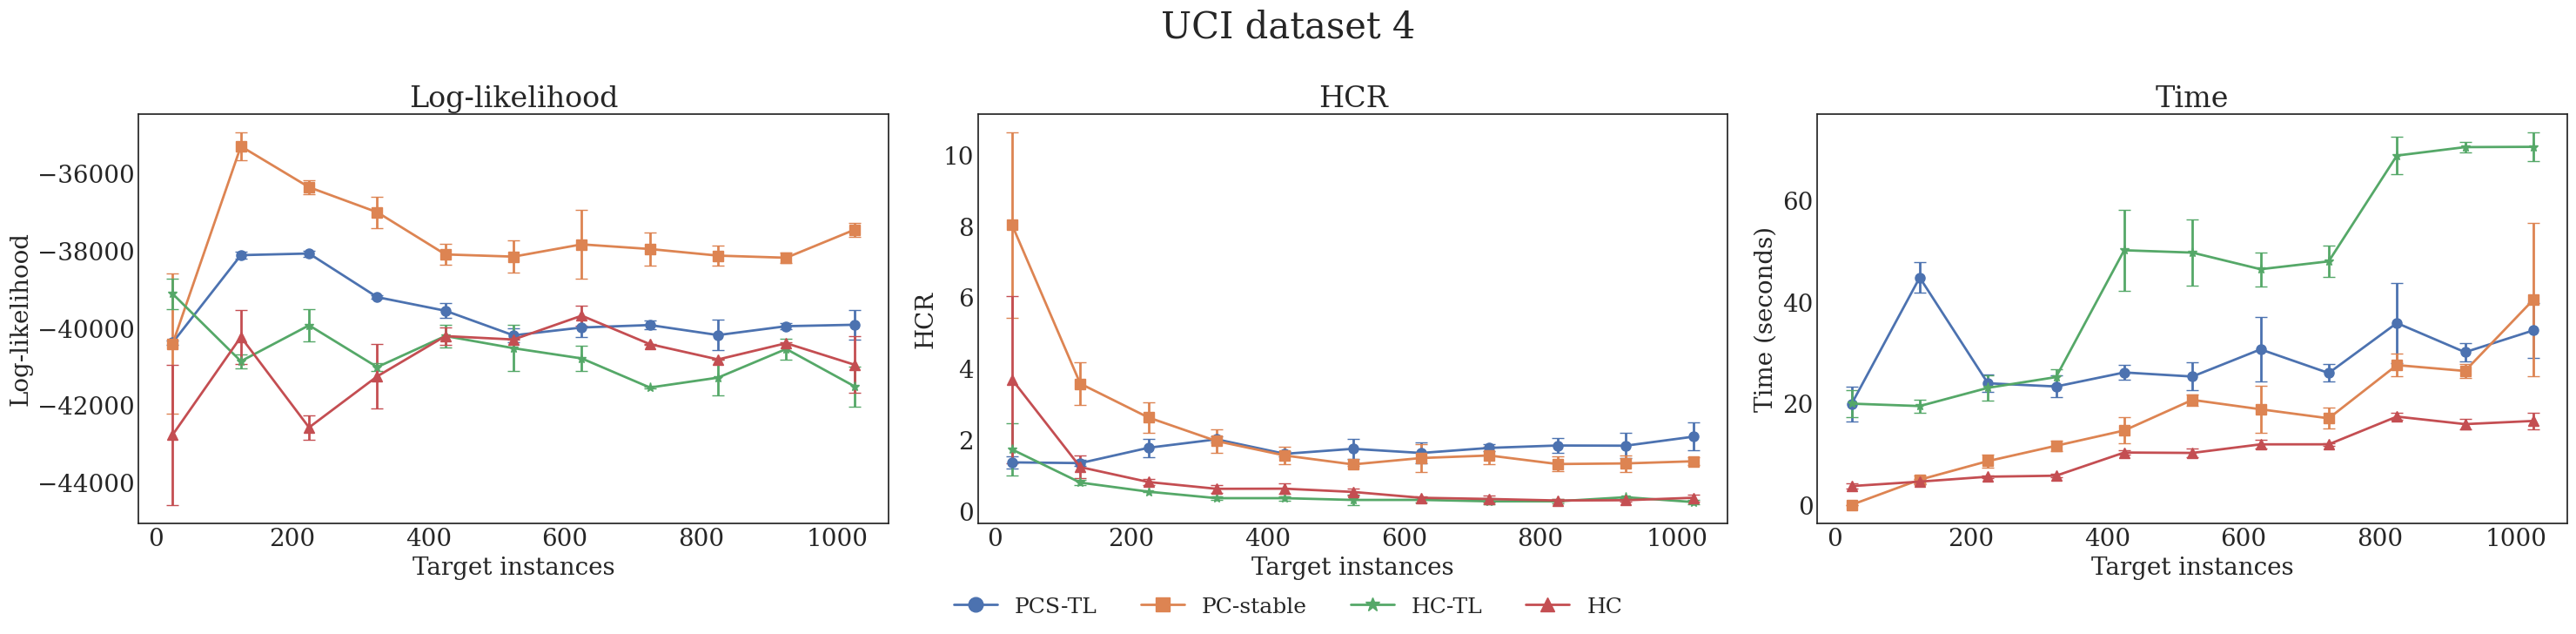

Processing 5 with 11 files


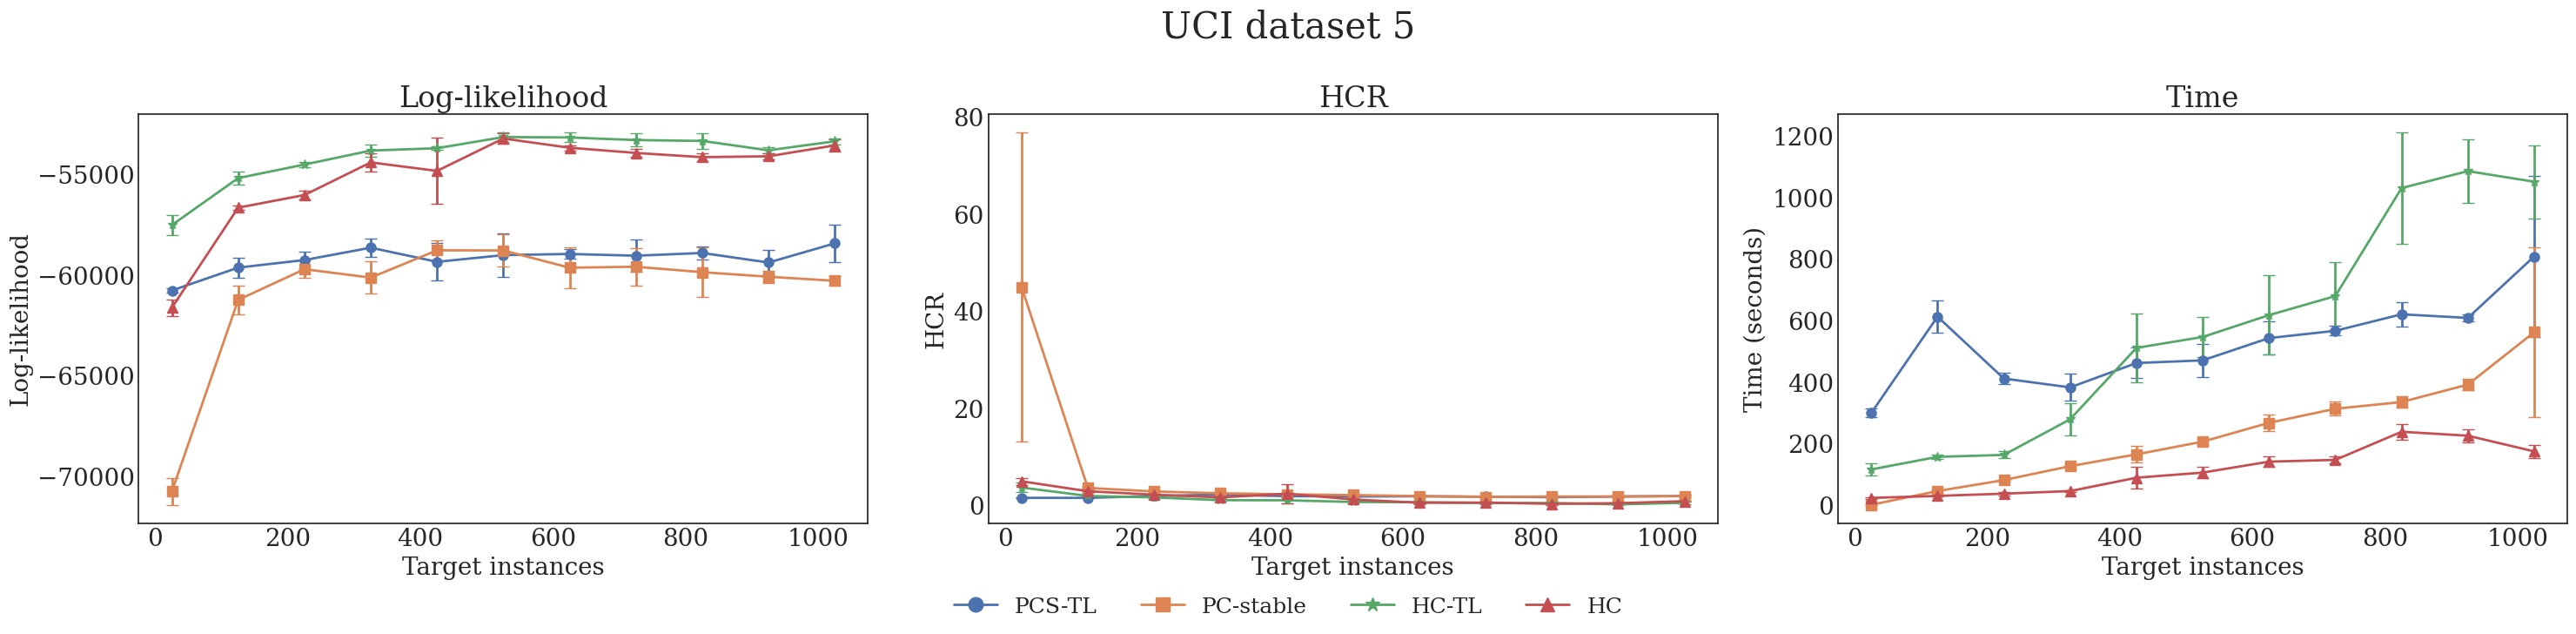

In [ ]:
uci5_51020p = plot3("exps/Risk-Slocal_3k_51020p/results_uciml/*.json", doPCHC=(True, True), save=True, figsize=(30, 7))

### PREPARE BERGMANN-HOMMEL

In [ ]:
prepare_010p = pd.concat([syntethic010p, bnlearn010p, uci5_010p], axis=0).reset_index(drop=True)
prepare_010p['modified'] = '010p'
prepare_51020p = pd.concat([synthetic51020p, bnlearn51020p, uci5_51020p], axis=0).reset_index(drop=True)
prepare_51020p['modified'] = '51020p'

for name, prepare_CD in (['010p','51020p'][prepare_010p, prepare_51020p]):
    prepare_CD = prepare_CD[prepare_CD['instances'] < 525]
    prepare_CD['network'] = prepare_CD['model'] + '_' + prepare_CD['instances'].astype(str)
    prepare_CD['dataset_name'] = prepare_CD['target'] + '_' + prepare_CD['instances'].astype(str) + '_' + prepare_CD['modified']

    for prepare, pth in zip([prepare_CD],[f"critical_diff/BOTH_{name}_shd_525"]):
        for metric in ['logl', 'HCR']:
            
            metric_cd = prepare[['model', 'dataset_name', metric]]
            metric_cd.columns = ['network', 'dataset_name', 'metric']
            transformed_metric_cd = metric_cd.pivot(index='dataset_name', columns='network', values='metric')
            print(transformed_metric_cd)
            os.makedirs(pth, exist_ok=True)
            transformed_metric_cd.to_csv(pth+ f"/{metric}.csv", index=False)




network                        HC         HC-TL     PC-stable        PCS-TL
dataset_name                                                               
1_125_010p          -38300.889476 -37946.144027 -39002.519321 -37157.281690
1_225_010p          -38565.436074 -37719.507195 -38557.403070 -37063.346869
1_25_010p           -41001.359957 -38156.851169 -42865.795309 -37713.296948
1_325_010p          -38688.569600 -37439.301805 -37962.419084 -37441.116032
1_425_010p          -38352.653077 -37421.514083 -37869.782647 -37330.738981
2_125_010p          -27735.219029 -27295.287454 -30771.686987 -29466.201340
2_225_010p          -27152.128695 -26495.564304 -29570.237697 -28696.371471
2_25_010p           -51066.399599 -28544.098783 -34157.325847 -29369.606621
2_325_010p          -27383.946917 -26929.197997 -29745.805808 -28650.288456
2_425_010p          -27479.527410 -27091.384673 -29284.106783 -28460.535792
3_125_010p          -11682.063442  -9867.219401 -26128.108998 -13425.119174
3_225_010p  

/tmp/ipykernel_20659/167637420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepare_CD['network'] = prepare_CD['model'] + '_' + prepare_CD['instances'].astype(str)
/tmp/ipykernel_20659/167637420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepare_CD['dataset_name'] = prepare_CD['target'] + '_' + prepare_CD['instances'].astype(str) + '_' + prepare_CD['modified']


### DRAW AVERAGE UCI GRAPHS

Plotting hc_25 with 3 networks
Plotting hc_25 with 3 networks
Plotting hc_25 with 3 networks
Plotting hc_25 with 3 networks
Plotting hc_25 with 3 networks
Plotting hctransfer_25 with 3 networks
Plotting hctransfer_25 with 3 networks
Plotting hctransfer_25 with 3 networks
Plotting hctransfer_25 with 3 networks
Plotting hctransfer_25 with 3 networks
Plotting pcot_25 with 3 networks
Plotting pcot_25 with 3 networks
Plotting pcot_25 with 3 networks
Plotting pcot_25 with 3 networks
Plotting pcot_25 with 3 networks
Plotting pcotransfer_25 with 3 networks
[['CO2CosIRValue', 'temperature', 'MOX1']] 1
Arcs [('temperature', 'MOX1'), ('humidity', 'CO2CosIRValue'), ('humidity', 'CO2MG811Value'), ('CO2CosIRValue', 'temperature'), ('CO2MG811Value', 'MOX1'), ('MOX1', 'CO2CosIRValue'), ('MOX2', 'CO2MG811Value'), ('MOX2', 'MOX1'), ('MOX2', 'MOX3'), ('MOX2', 'MOX4'), ('MOX4', 'MOX1'), ('MOX4', 'MOX3'), ('COValue', 'MOX2'), ('COValue', 'MOX3')]
Combination ('CO2CosIRValue', 'temperature') from 1 cycles
A

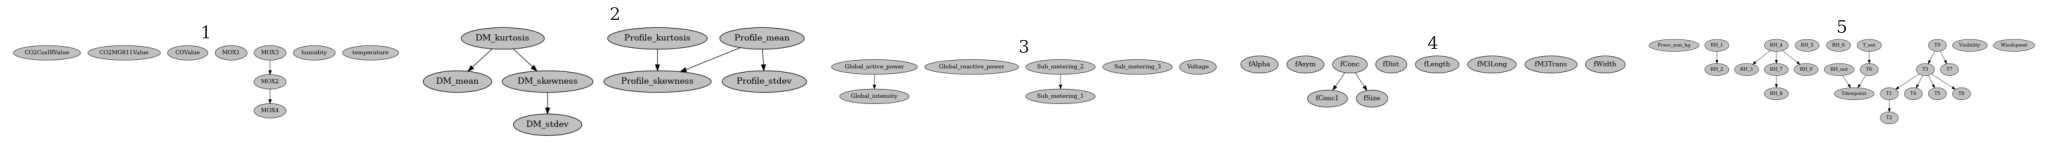

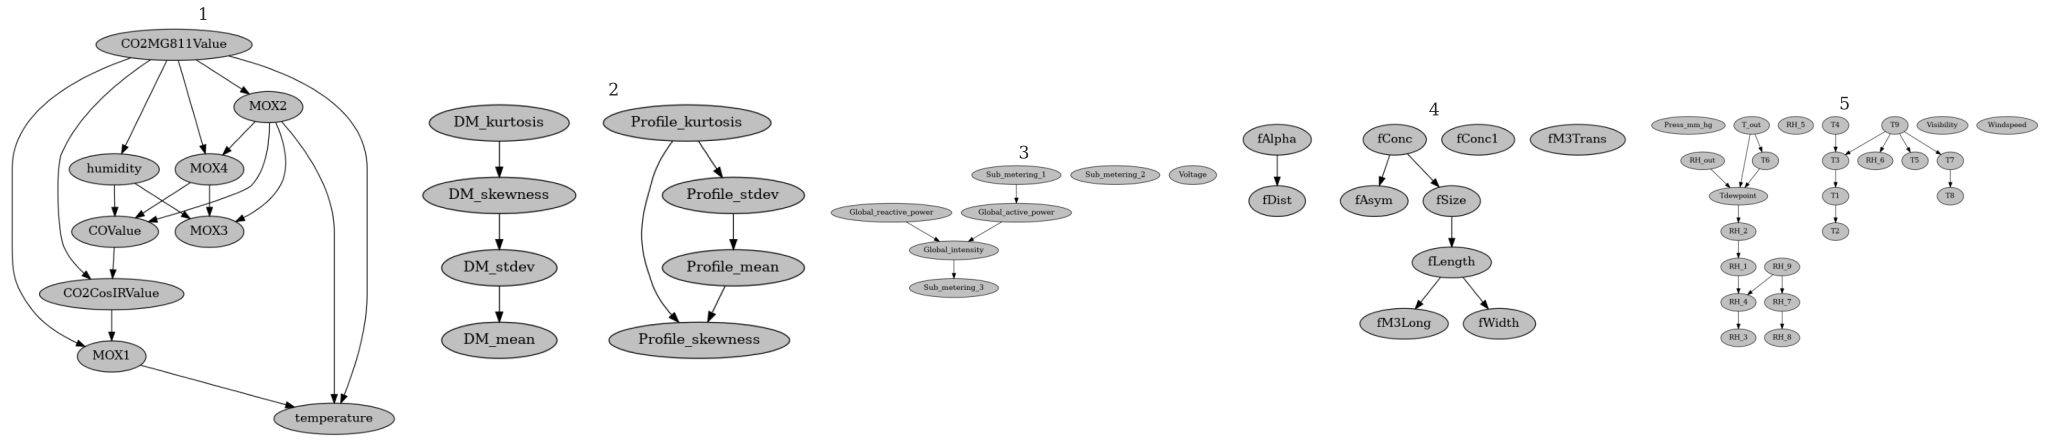

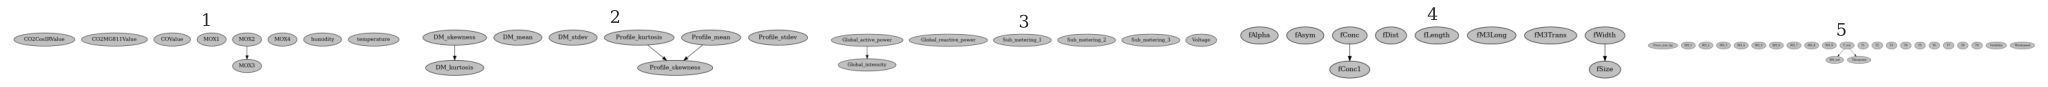

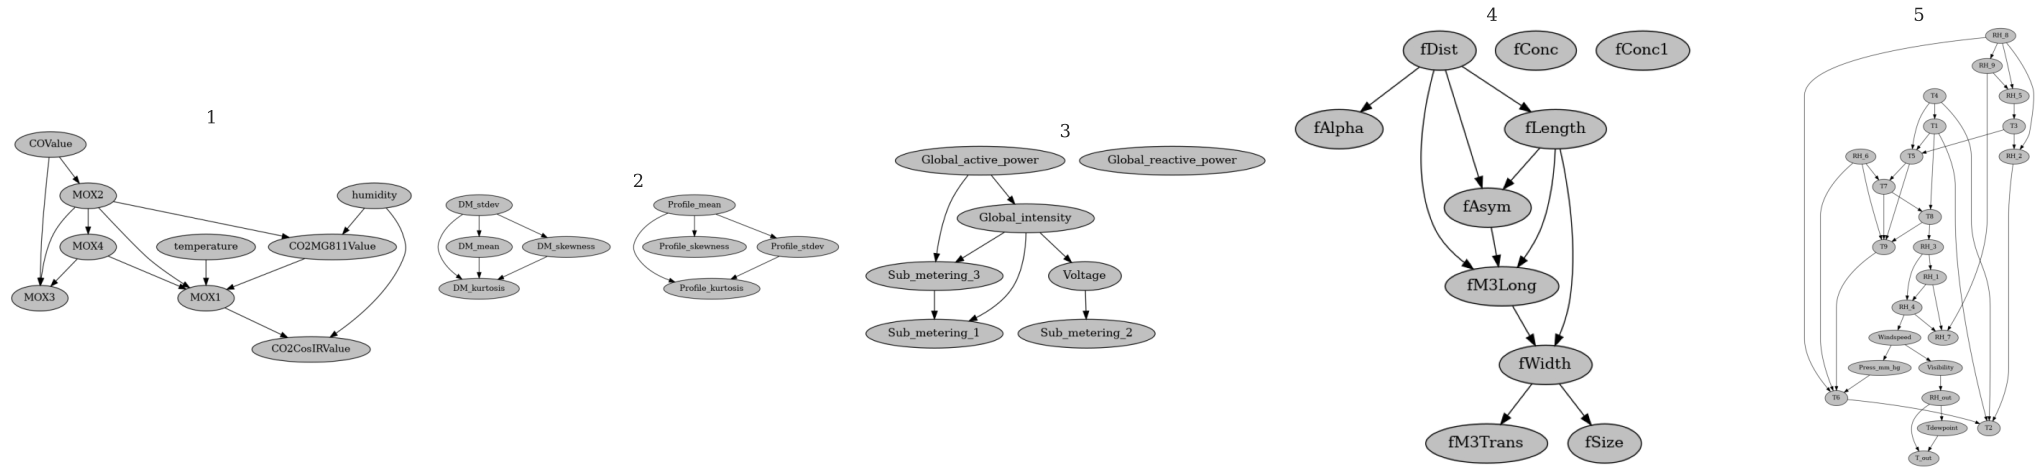

In [ ]:
path = "exps/Risk-Slocal_3k_51020p/results_uciml/*_T25/*_1.pickle"
dirs = ns.natsorted(glob.glob(path))
mapname = {"pcotransfer": "pc-transfer","pcot": "pc",
           "hctransfer": "hc-transfer","hc": "hc"}
prepare = defaultdict(list)
for f in dirs:
    basename = os.path.basename(f)
    dirname = os.path.dirname(f)
    tinstances = int(dirname[-2:])
    spbnname = dirname.split("/")[-1].split("_")[0]
    modelname =basename.split("_")[0]
    mapmodelname = mapname[modelname]
    
    
    models = []
    for p in glob.glob(os.path.join(dirname, f"{modelname}_*.pickle")):
        model = pbn.load(p)
        models.append(model)

    prepare[f"{modelname}_{tinstances}"].append(models)




for key, listnets in prepare.items():
    fig, axes = plt.subplots(1, 5, figsize=(30, 7))
    for n,(net, ax) in enumerate(zip(listnets, axes)):   
        print(f"Plotting {key} with {len(net)} networks")
        avgdag = average_dag(net, threshold=0.5)
        arclist = set(avgdag['arcs'])
        G = nx.DiGraph(arclist)
        cycles = [cycle for cycle in nx.simple_cycles(G)]
        
        if len(cycles) > 0:            
            total_combs, nkeys = cycles_combinations(G, cycles)     
            print(cycles, nkeys)      
            comb = random.choice(total_combs)
            print(f"Arcs {avgdag['arcs']}")
            print(f"Combination {comb} from {nkeys} cycles")
         
            if nkeys>1:
                arclist = arclist - set(comb)
            else:
                arclist = arclist - set([comb])
                
            print(f"Arcs left: {arclist}")
        
            
        dag = pbn.KDENetwork(arcs=list(arclist), nodes=avgdag['nodes'])    
        plot_model(dag,ax)
        ax.set_title(f"{n+1}", fontsize=18)
        
        draw_model(dag, f'exps/Risk-Slocal_3k_51020p/results_uciml/{key}_synthetic{n+1}_networks')

    plt.tight_layout()


    